# Gramener Case Study

In [90]:
"""
###################################################################################################################################
##  
##  Program Name        : Gramener Case Study
##
##  Description         : Loan Risk Analysis
##
##  Author(s)           : Jagdish Mirchandani / Bhaskara Bhamidi / Sandip Roy
##  
###################################################################################################################################
"""
import importlib.util
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
plt.rcdefaults()
from scipy.stats.stats import pearsonr

In [91]:
# Load the csv file
loandf = pd.read_csv("loan.csv",encoding = "ISO-8859-1", low_memory=False)

# check the dataframe
loandf.info()

# check the number of rows and columns
loandf.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


(39717, 111)

## Data Cleaning

In [92]:
# Get the percentage of null values for each columns
round(loandf.isnull().sum() / len(loandf.index) * 100, 2)

# Remove Columns with 90% or null values
loandf = loandf.loc[:, (round(loandf.isnull().sum() / len(loandf.index) * 100, 2) < 90.00)]

# Verify the dataframe after removing columns
round(loandf.isnull().sum() / len(loandf.index) * 100, 2)

# column mths_since_last_delinq" has more than 60% null values, drop the column
loandf.drop('mths_since_last_delinq', axis=1, inplace=True)

# find out columns that have single value for all the rows, such columns need to be dropped
sv_columns = loandf.nunique()
sv_columns = sv_columns[sv_columns.values==1]
print("Following columns have single value for all the rows, need to be dropped:\n",sv_columns)

# Columns pub_rec_bankruptcies & pub_rec seems to have contain similar information, drop pub_rec_bankruptcies.

# Remove the columns identified above and drop few more unnecessary columns like url etc. 
column = ['id', 'grade', 'url', 'funded_amnt', 'emp_title', 'earliest_cr_line', 'pymnt_plan', 'desc',
               'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
               'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
               'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'collection_recovery_fee', 'inq_last_6mths',
               'tax_liens', 'delinq_amnt', 'chargeoff_within_12_mths','acc_now_delinq','application_type','pub_rec_bankruptcies']

loandf.drop(column, axis=1, inplace=True)

# ‘purpose’ and ‘title’ has redundant information,purpose can be used later, remove title column.
loandf.drop('title', axis=1, inplace=True)

# Check the home_ownership column
loandf["home_ownership"].unique()
loandf["home_ownership"].value_counts()
# Remove rows which has “NONE” as the value in “home_ownership” column.
loandf.drop(loandf[loandf['home_ownership'].isin(['OTHER', 'NONE', 'ANY'])].index,inplace=True)

# check the number of null values in each column again
round(loandf.isnull().sum() / len(loandf.index) * 100, 2)

# check the number of rows and columns again
loandf.shape

Following columns have single value for all the rows, need to be dropped:
 pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64


(39616, 21)

##### Data Formatting.

In [93]:
# Convert dates to datetime object.
loandf["issue_d"] = pd.to_datetime(loandf["issue_d"], format="%b-%y")

# Round to 2 decimal places 
loandf["funded_amnt_inv"] = round(loandf["funded_amnt_inv"], 2)
loandf["installment"] = round(loandf["installment"], 2)

# convert the term column to intiger type by stripping off the text "months".
loandf["term"] = loandf["term"].str.replace(" months", "").astype("int64")

# similarly stripp off "%" from interest rate column and round to 2 decimal places
loandf["int_rate"] = loandf["int_rate"].str.replace("%", "").astype("float64")
loandf['int_rate'] = round(loandf['int_rate'], 2)


# similarly stripp off "%" from revol_util column and round to 2 decimal places
loandf["revol_util"] = loandf["revol_util"].str.replace("%", "").astype("float64")
loandf['revol_util'] = round(loandf['revol_util'], 2)

# strip off texts from emp_lenght field and convert it into a float variable
loandf["emp_length"] = loandf["emp_length"].str.replace("< 1", "0")
intab = "+years"
outtab = "      "
trantab = str.maketrans(intab, outtab)
loandf["emp_length"] = loandf["emp_length"].str.translate(trantab).astype("float64")

# impute employee length with mean and round to 2 decimal places
loandf.emp_length.fillna(loandf.emp_length.mean(),inplace = True)
loandf['emp_length'] = round(loandf['emp_length'], 2)

# Univariate analysis

In [94]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [95]:
def draw_bar_chart(df, x, y, width, height, title='', xlabel='', ylabel='', legend=None, message='', showBarVals=False):
    # Restore the rc params from Matplotlib’s internal defaults.
    plt.rcdefaults() 
    
    # Set figure size
    plt.figure(figsize=(width, height))
    
    # Plot bar chart of data frame 
    ax = sns.barplot(x=x, y=y, data=df)
    
    if showBarVals == True:
        show_values_on_bars(ax)
    
    if xlabel.strip():
        plt.xlabel(xlabel)
    
    if ylabel.strip():    
        plt.ylabel(ylabel)
    
    if legend is not None:
        plt.legend(legend)
    
    if title.strip():
        plt.title(title)
        
    plt.show()
    
    if message.strip():
        print(message)

In [96]:
def draw_bar_chart_subplot(df, x, y, title='', xlabel='', ylabel='',
                           legend=None, message='', showBarVals=False, show=False,
                           subplot_arg1=2, subplot_arg2=2, subplot_arg3=1):

    plt.subplot(subplot_arg1, subplot_arg2, subplot_arg3)
    
    # Plot bar chart of data frame 
    ax = sns.barplot(x=x, y=y, data=df)
    
    if showBarVals == True:
        show_values_on_bars(ax)
    
    if xlabel.strip():
        plt.xlabel(xlabel)
    
    if ylabel.strip():    
        plt.ylabel(ylabel)
    
    if legend is not None:
        plt.legend(legend)
    
    if title.strip():
        plt.title(title)
    
    if show == True:
        plt.show()
    
    if message.strip():
        print(message)

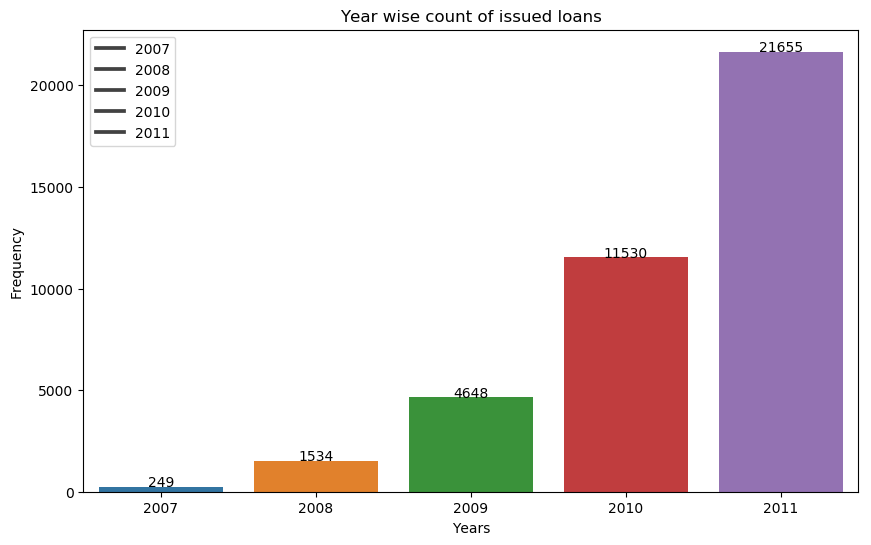

Observation: Increase in loan issued year by year.


In [97]:
# Year wise bar chart from issue_d column 
yearwise_loans_issued = loandf.groupby(loandf.issue_d.dt.year).size().reset_index(name='Frequency')
draw_bar_chart(yearwise_loans_issued, "issue_d", "Frequency", 10, 6,
               'Year wise count of issued loans',
               'Years', 'Frequency', yearwise_loans_issued['issue_d'],
               'Observation: Increase in loan issued year by year.',
              True)

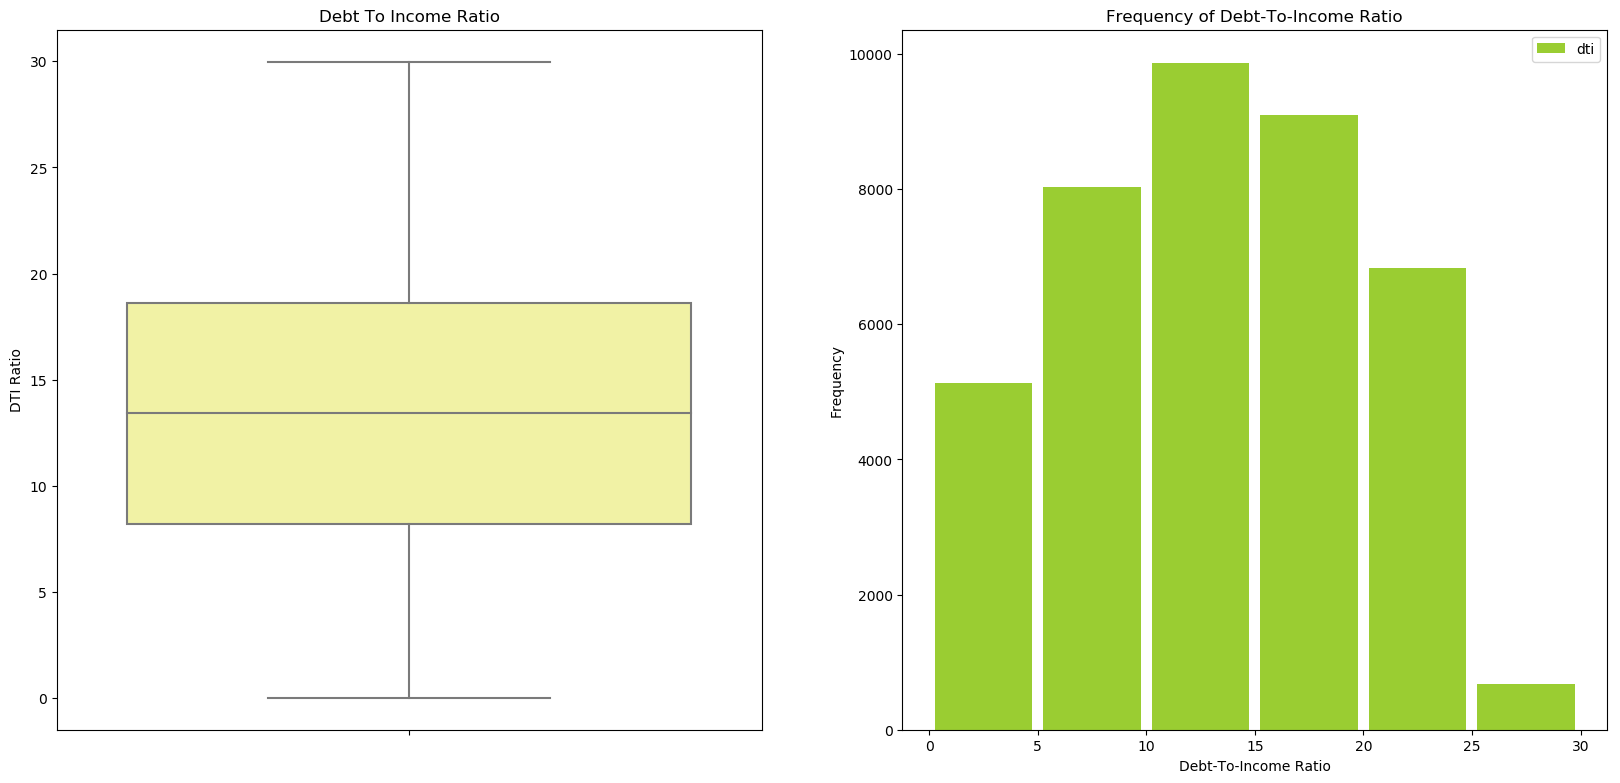

In [98]:
# Debt-To-Income Ratio(dti) is the percentage of a consumer's monthly gross income that goes 
# toward paying debts excluding mortgage and the requested LC loan

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
ax = sns.boxplot(y='dti', data=loandf, palette='terrain_r')
plt.ylabel('DTI Ratio')
plt.title('Debt To Income Ratio')

#Frequency Chart 
dti = loandf['dti']
legend = ['dti']
plt.subplot(2,2,2)
plt.hist([dti], color=['yellowgreen'], bins=6, rwidth=0.9)
plt.xlabel("Debt-To-Income Ratio")
plt.ylabel("Frequency")
plt.legend(legend)
plt.xticks(np.arange(min(dti), max(dti)+5, 5))
plt.title('Frequency of Debt-To-Income Ratio')
plt.show()

# Observations: 
# 1. dti values are equally distributed along the median between 25-75 percentile with max value at 30 approx,minimum at 0.
# 2. Maximum borrowers given loan having DTI value between 10-15%

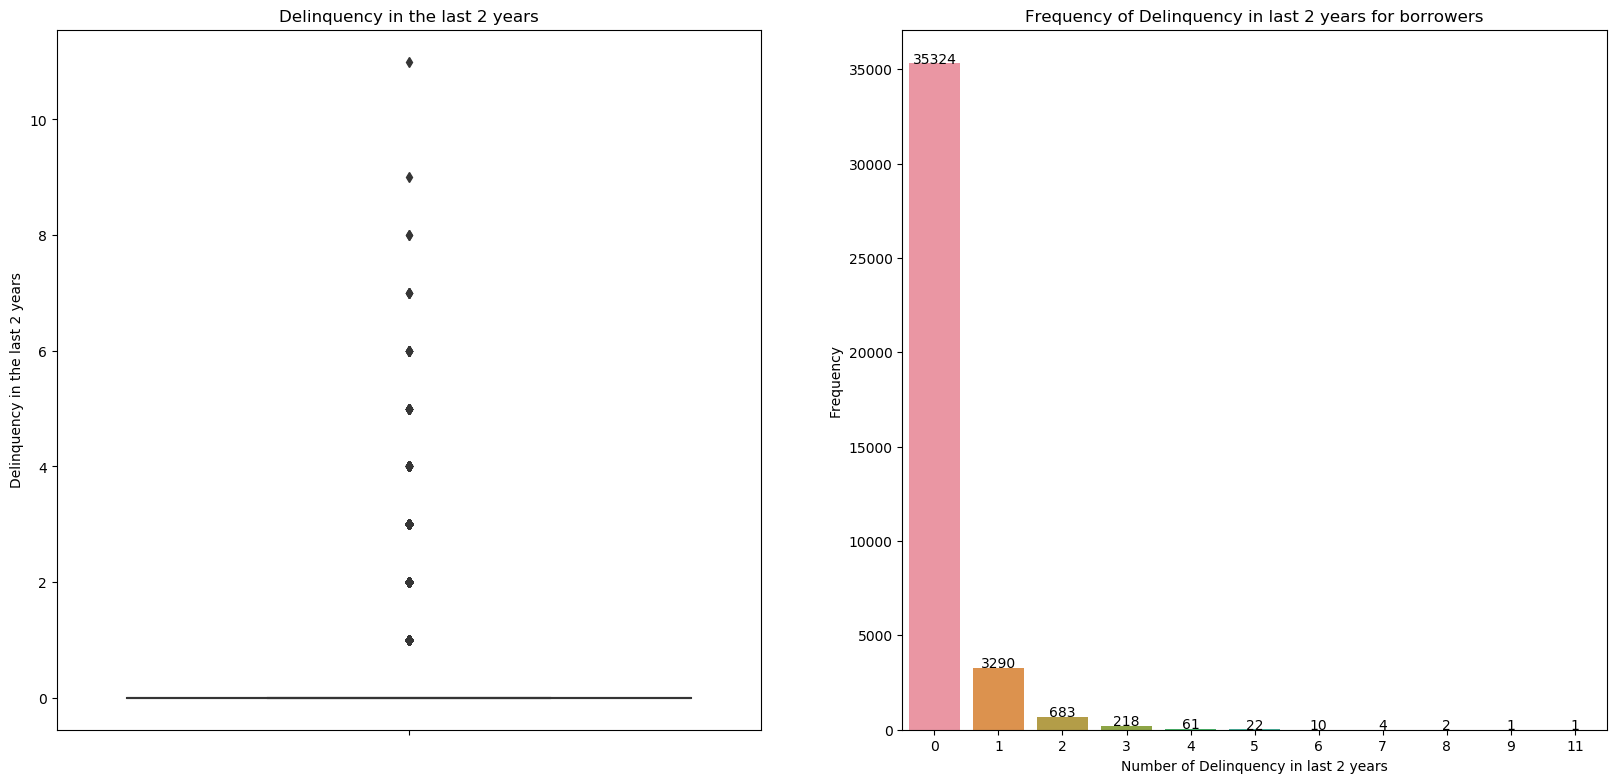

In [99]:
# Delinquency in past 2 Years(delinq_2yrs) is The number of 30+ days past-due incidences of delinquency
# ( failure to make a required payment )in the borrower's credit file for the past 2 years

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
ax = sns.boxplot(y='delinq_2yrs', data=loandf, palette='viridis')
plt.ylabel('Delinquency in the last 2 years')
plt.title('Delinquency in the last 2 years')

#Frequency Chart 
delinq_2yrs_values = pd.DataFrame(loandf['delinq_2yrs'].value_counts())
plt.subplot(2,2,2)
ax = sns.barplot(x=delinq_2yrs_values.index, y="delinq_2yrs", data=delinq_2yrs_values)
show_values_on_bars(ax)
plt.xlabel("Number of Delinquency in last 2 years")
plt.ylabel("Frequency")
plt.title('Frequency of Delinquency in last 2 years for borrowers')
plt.show()

# Observations:
# 1.Most of the delinq_2yrs values are 0.
# 2.outliers and the max value is 11.

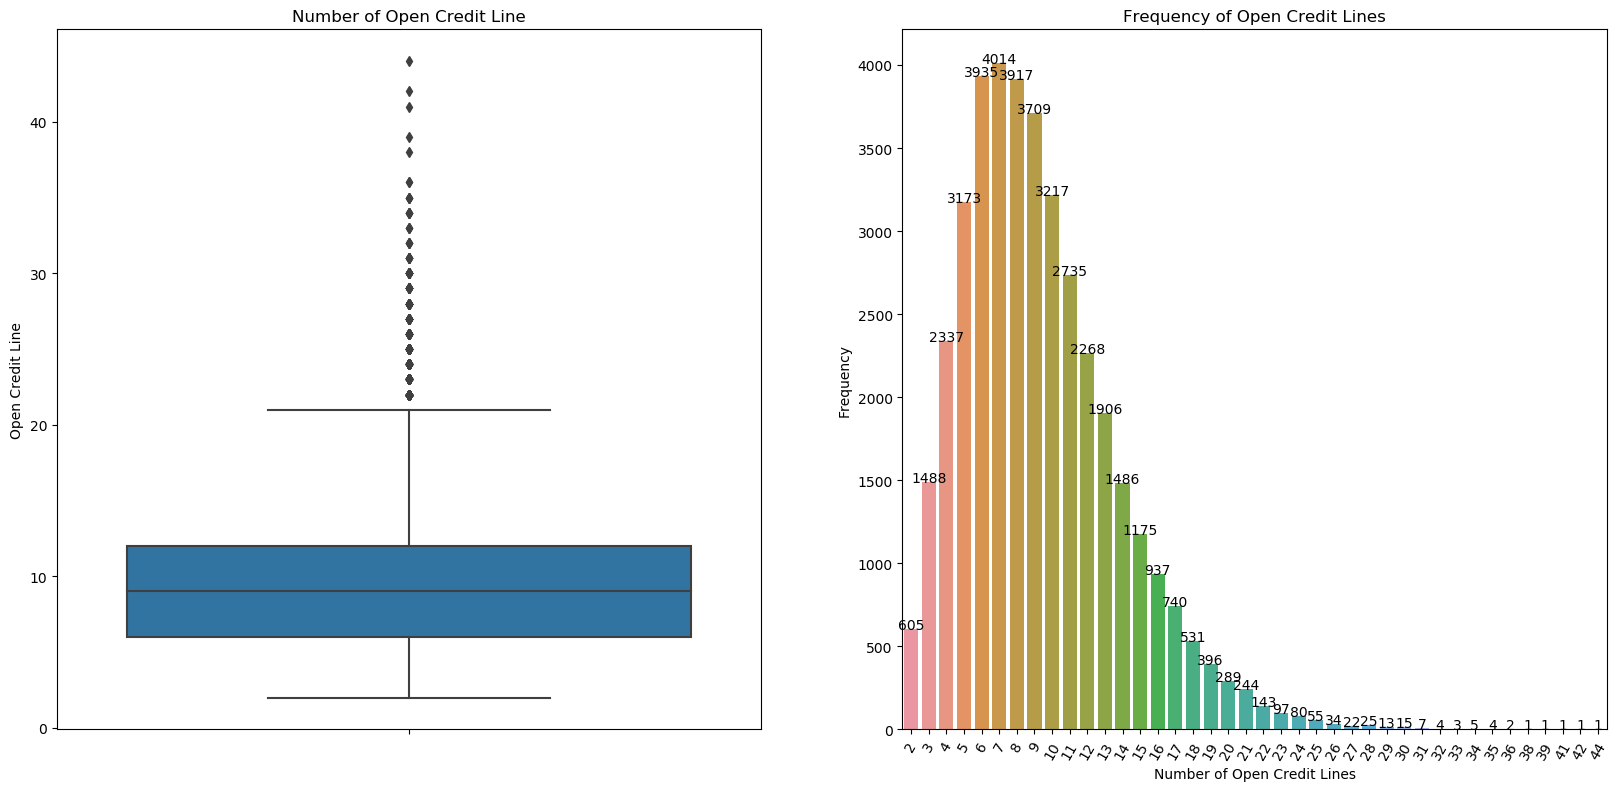

In [100]:
# Number of open credit lines in the borrower's credit file(open_acc)
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.boxplot(y=loandf['open_acc'])
plt.ylabel('Open Credit Line')
plt.title('Number of Open Credit Line')

#Frequency Chart 
open_acc_values = pd.DataFrame(loandf['open_acc'].value_counts())
plt.subplot(2,2,2)
ax = sns.barplot(x=open_acc_values.index, y="open_acc", data=open_acc_values)
show_values_on_bars(ax)
plt.xlabel("Number of Open Credit Lines")
plt.ylabel("Frequency")
plt.title('Frequency of Open Credit Lines')
plt.xticks(rotation=60)
plt.show()

# Observations:
# 1. open_acc values is equally distributed along the median(=9) for 25-75 percentile.
# 2. There are some outliers.

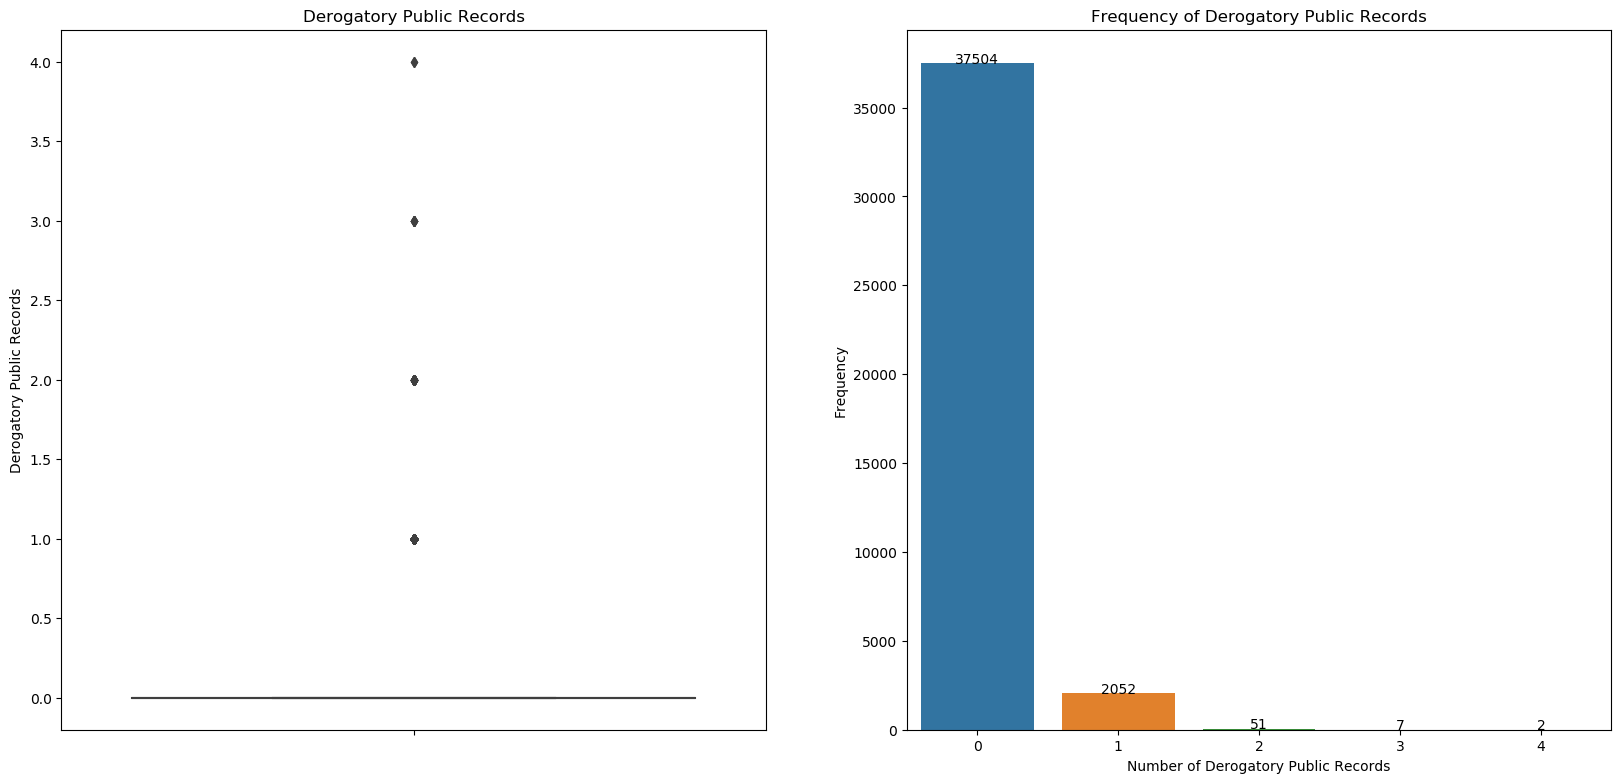

In [101]:
# Number of derogatory public records(pub_rec)
# Public records and collections are derogatory items in credit report because they all reflect financial obligations
# that were not paid as agreed

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.boxplot(y=loandf['pub_rec'])
plt.ylabel('Derogatory Public Records')
plt.title('Derogatory Public Records')

#Frequency Chart 
pub_rec_values = pd.DataFrame(loandf['pub_rec'].value_counts())
plt.subplot(2,2,2)
ax = sns.barplot(x=pub_rec_values.index, y="pub_rec", data=pub_rec_values)
show_values_on_bars(ax)
plt.xlabel("Number of Derogatory Public Records")
plt.ylabel("Frequency")
plt.title('Frequency of Derogatory Public Records')
plt.show()

# Observations:
# 1. Most of the pub_rec values are 0.
# 2. There are outliers in the column.

In [102]:
# revol_util is the Percentage of credit the borrower is using relative to all available revolving credit.
# As seen earlier, there are null values in this column, need to impute these null values with some value.
# lets check mean and median.
print("Mean:",round(loandf.revol_util.mean(), 2))
print("Median:",round(loandf.revol_util.median(),2))
# Since Mean & Median, both values are very close, its safe to impute revol_util null values by median.
loandf.loc[loandf.revol_util.isnull(),'revol_util'] =  loandf.revol_util.median()

# Check for null values
loandf.revol_util.isnull().sum() # All good, no null values.

Mean: 48.85
Median: 49.3


0

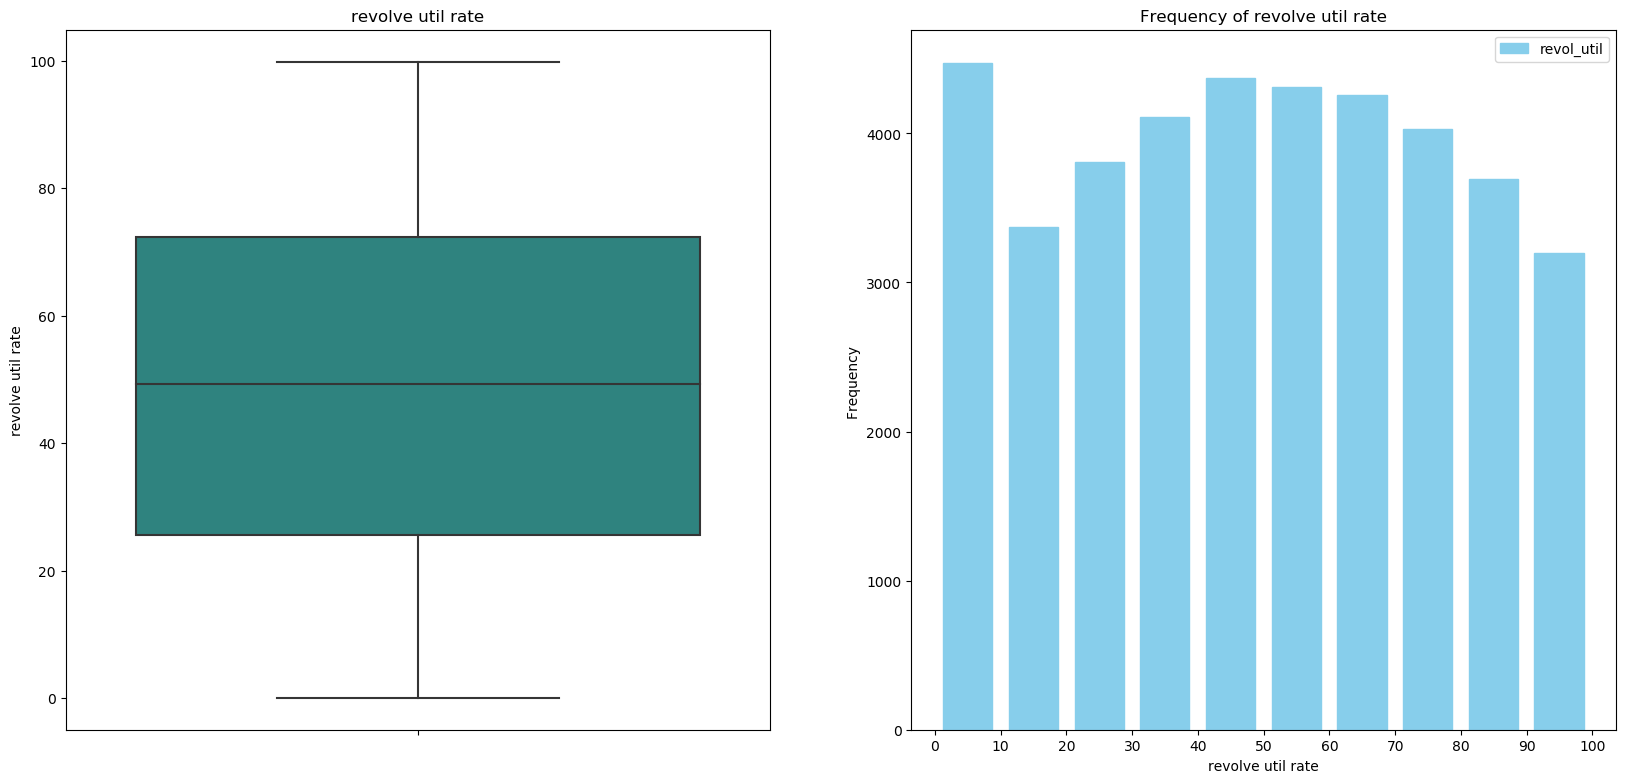

In [103]:
#revolve util rate(revol_util)

# Ploting revo_util column
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=loandf['revol_util'], palette='viridis')
plt.ylabel('revolve util rate')
plt.title('revolve util rate')

#Frequency Chart
revol_util = loandf['revol_util']
legend = ['revol_util']
plt.subplot(2,2,2)
plt.hist([revol_util], color = "skyblue", ec="skyblue", bins=10, rwidth=0.75)
plt.xlabel("revolve util rate")
plt.ylabel("Frequency ")
plt.xticks(np.arange(min(revol_util), max(revol_util)+10, 10))
plt.legend(legend)
plt.title('Frequency of revolve util rate')
plt.show()

# Observations:
# 1. values are equally distributed along the median between 25-75 percentile'.
# 2. Maximum value approx 100
# 3. Maximum borrowers have revolve credit utilization rate in the range 0-10%.

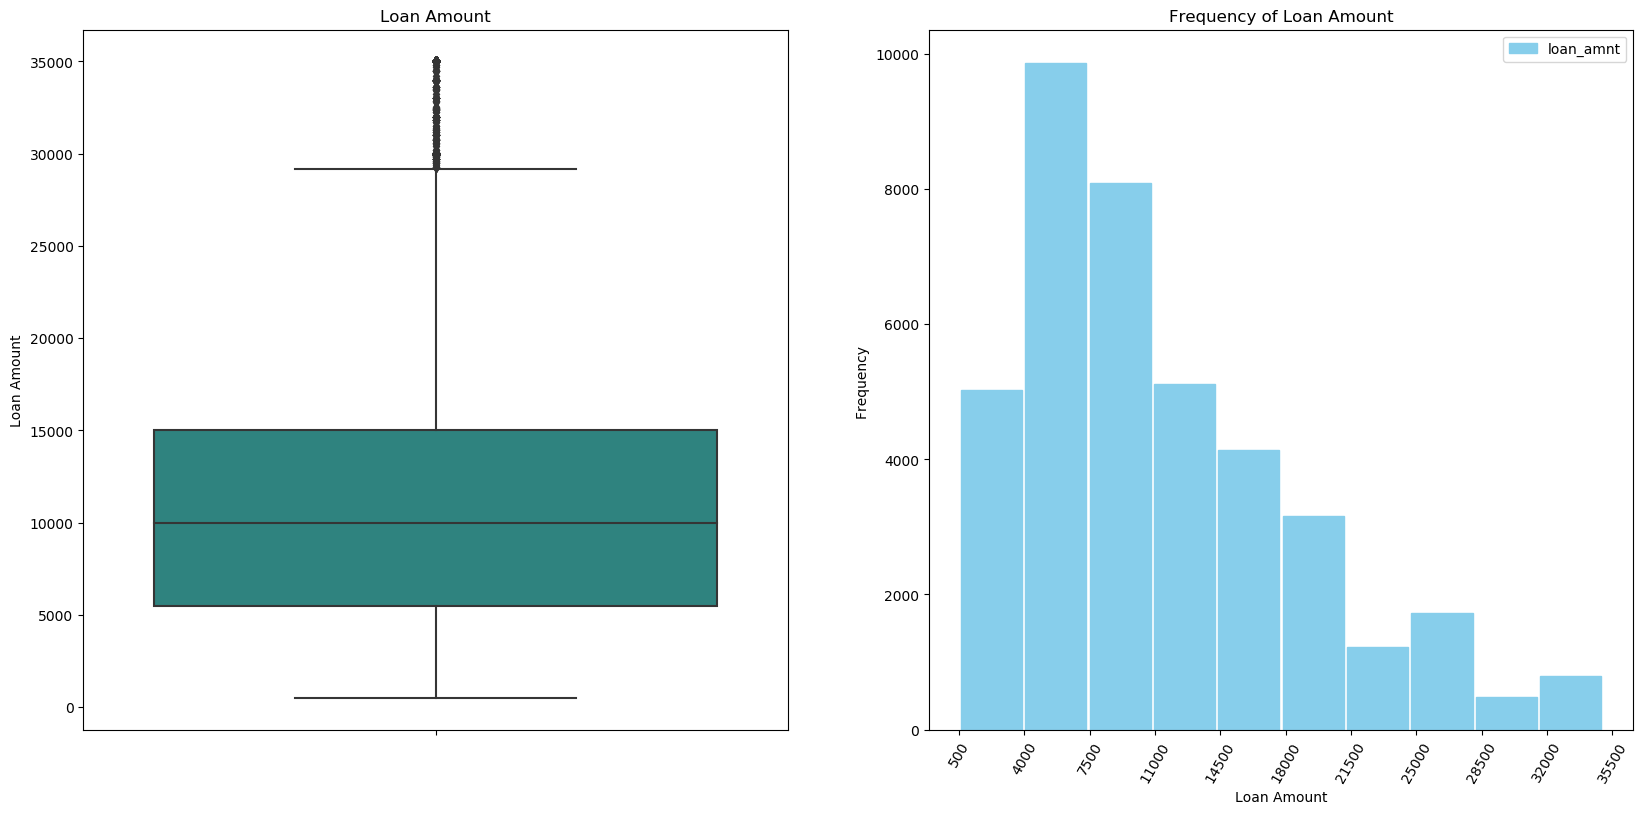

In [104]:
# loan_amnt analysis

# Plot the distribution bar for loan_amnt 
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=loandf['loan_amnt'], palette='viridis')
plt.ylabel('Loan Amount')
plt.title('Loan Amount')

#Frequency Chart
loan_amnt = loandf['loan_amnt']
legend = ['loan_amnt']
plt.subplot(2,2,2)
plt.hist([loan_amnt], color = "skyblue", ec="skyblue", bins=10, rwidth=0.95)
plt.xlabel("Loan Amount")
plt.ylabel("Frequency ")
plt.xticks(np.arange(min(loan_amnt), max(loan_amnt)+3500, 3500), rotation=60)
plt.legend(legend)
plt.title('Frequency of Loan Amount')
plt.show()

# Observations:
# 1. Most frequently taken loan amount: $4000 to $7500
# 2. Some outliers can be seen in the graph below.

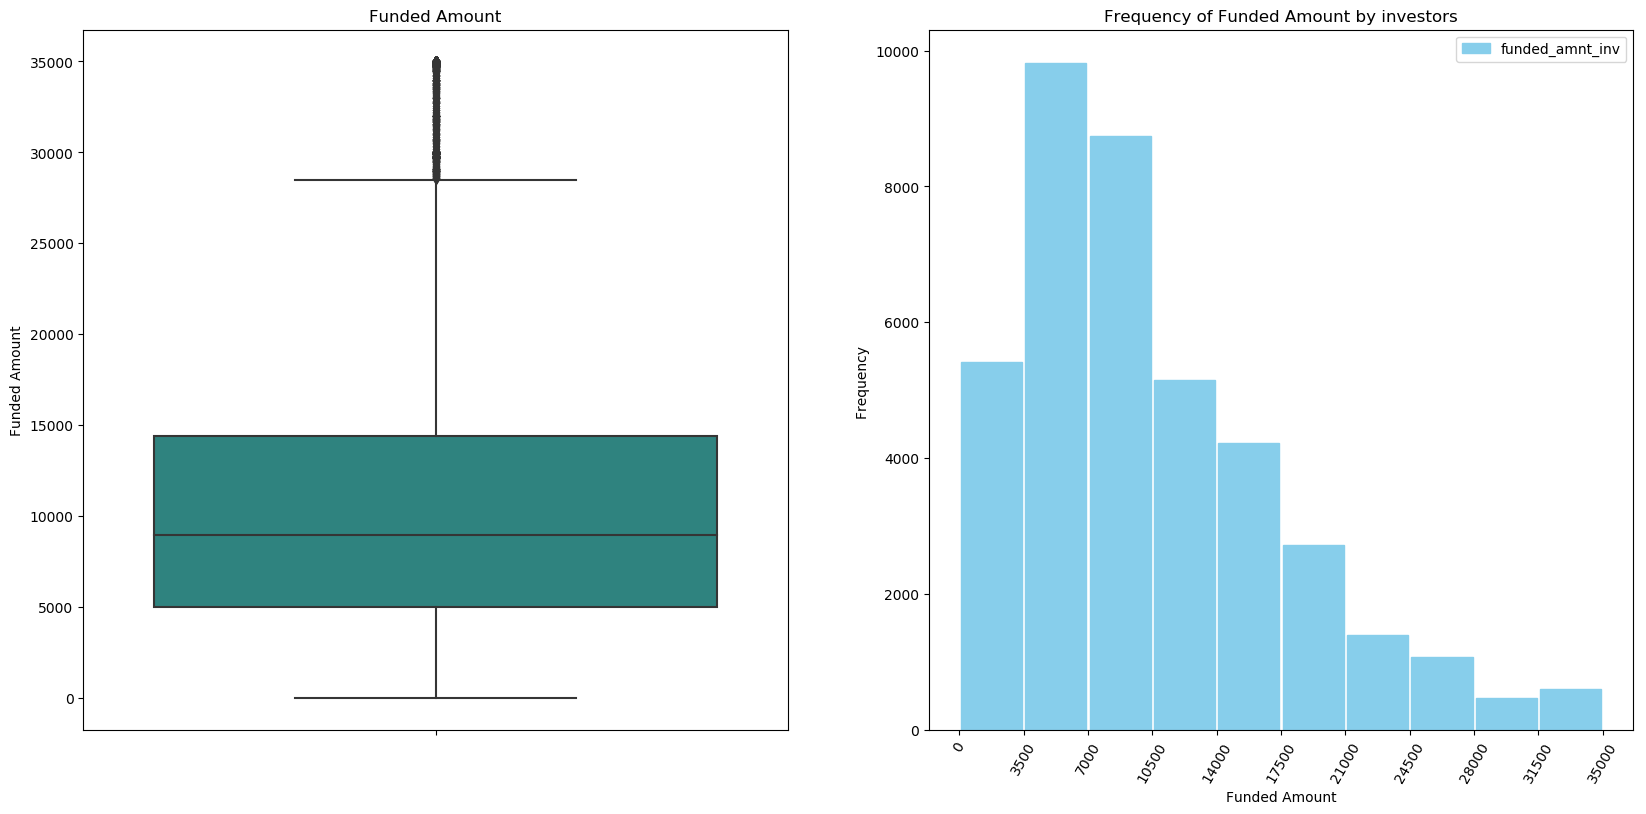

In [105]:
# distribution plot for funded_amnt_inv 
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=loandf['funded_amnt_inv'], palette='viridis')
plt.ylabel('Funded Amount')
plt.title('Funded Amount')

#Frequency Chart
funded_amnt_inv = loandf['funded_amnt_inv']
legend = ['funded_amnt_inv']
plt.subplot(2,2,2)
plt.hist([funded_amnt_inv], color = "skyblue", ec="skyblue", bins=10, rwidth=0.95)
plt.xlabel("Funded Amount")
plt.ylabel("Frequency ")
plt.xticks(np.arange(min(funded_amnt_inv), max(funded_amnt_inv)+3500, 3500), rotation=60)
plt.legend(legend)
plt.title('Frequency of Funded Amount by investors')
plt.show()

# Observations: 
# 1. most frequently invested is between $3500 to $7000 .',
# 2. Again, some outliers can be seen in the graph

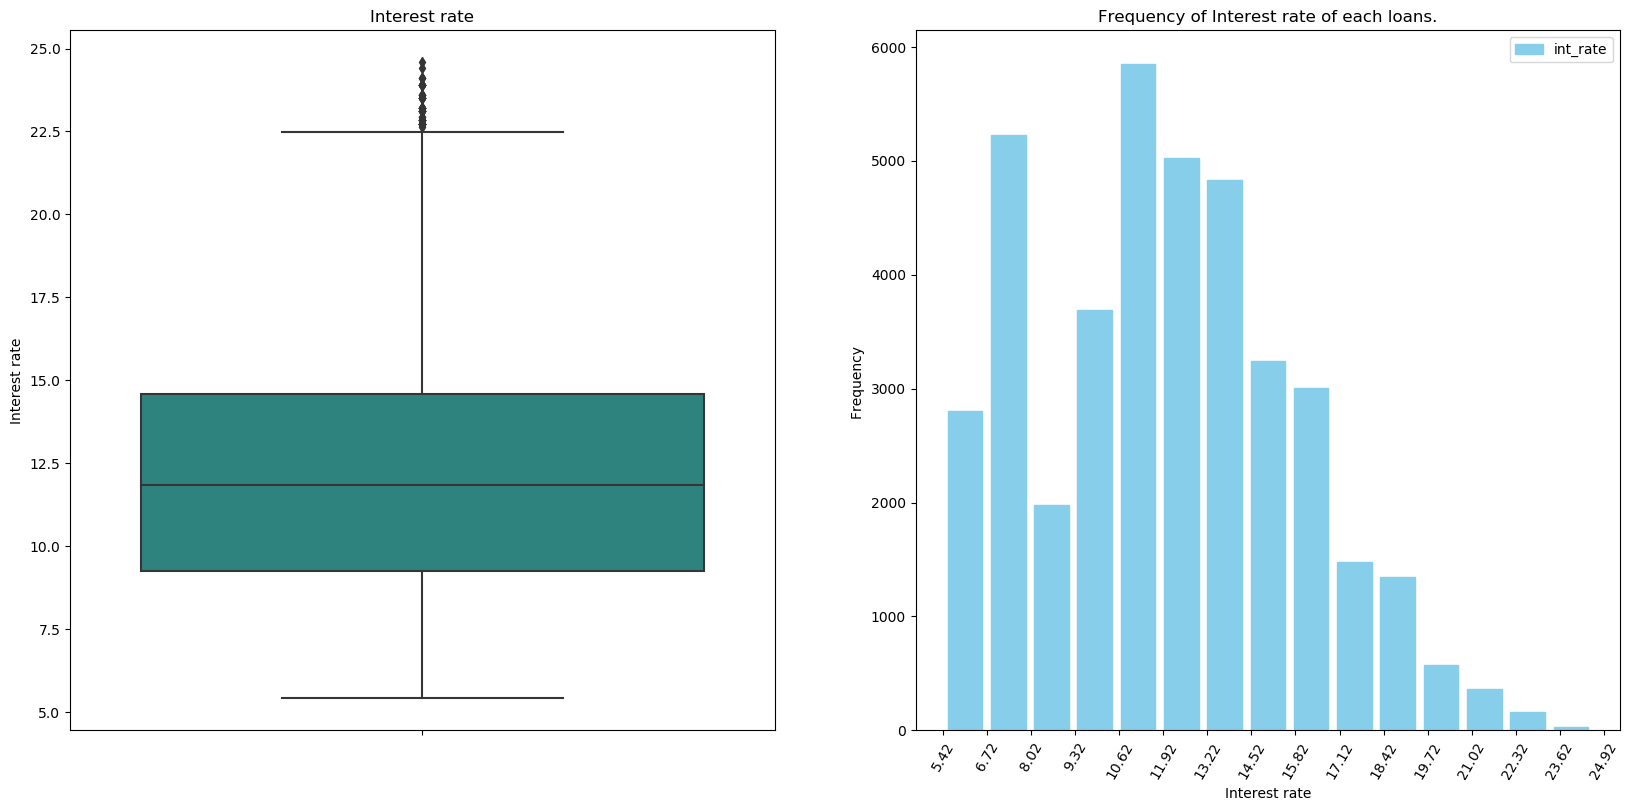

In [106]:
# Lets see how interest rate is distributed
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=loandf['int_rate'], palette='viridis')
plt.ylabel('Interest rate')
plt.title('Interest rate')

#Frequency Chart
int_rate = loandf['int_rate']
legend = ['int_rate']
plt.subplot(2,2,2)
plt.hist([int_rate], color = "skyblue", ec="skyblue", bins=15, rwidth=0.80)
plt.xlabel("Interest rate")
plt.ylabel("Frequency ")
plt.xticks(np.arange(min(int_rate), max(int_rate)+1.3, 1.3), rotation=60)
plt.legend(legend)
plt.title('Frequency of Interest rate of each loans.')
plt.show()

# Observations:
# 1. most frequent Interest rate is in the range 10.6% to 11.9% .'
# 2. some outliers can be clearly seen in the graph below, 22.5 to 25%.

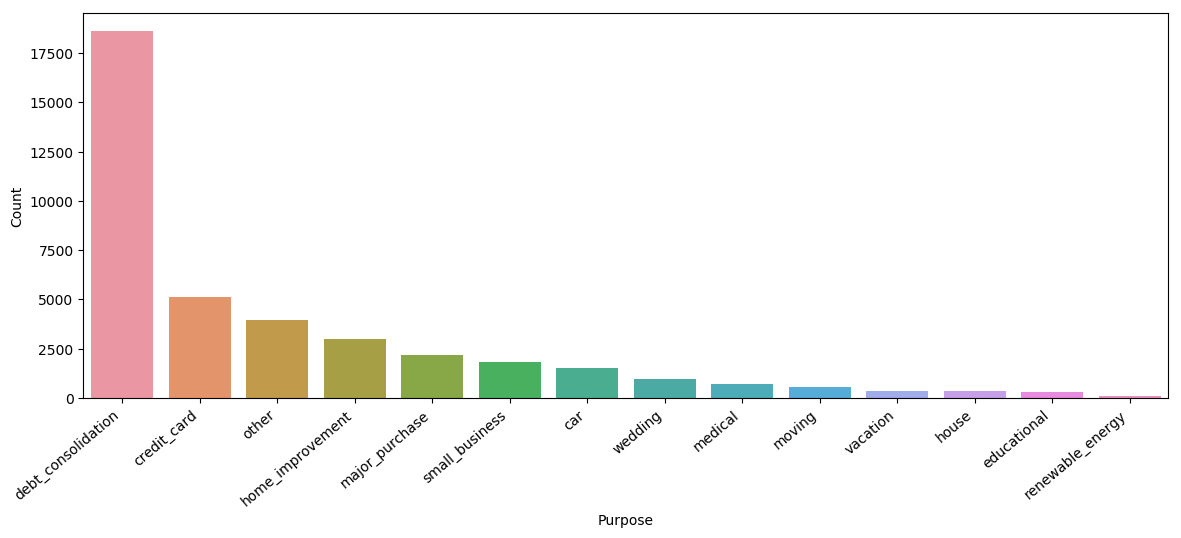

In [107]:
# For unordered categorical variables, use count plot
# count plot for 'purpose'
plt.figure(figsize=(14, 5))
fig = sns.countplot(loandf.purpose.dropna(), order = loandf.purpose.value_counts().index)
fig.set(xlabel='Purpose', ylabel='Count')
fig.set_xticklabels(fig.get_xticklabels(), rotation=40, ha="right")
plt.show()

# Observation: maximum number of loans are taken for debt_consolidation

The unique values in term column are,  [36 60]


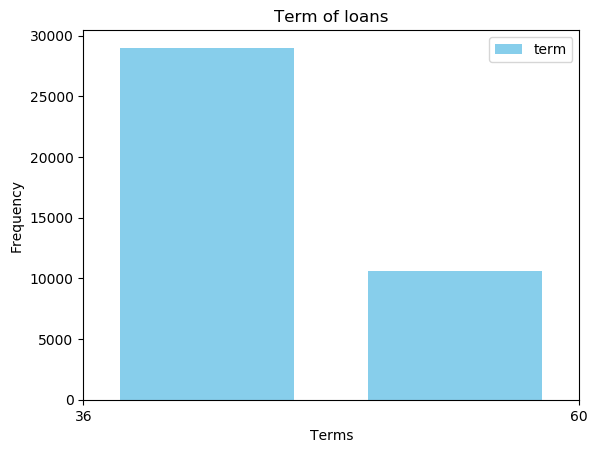

In [108]:
# Ananlys of the column "term"
# First check how many unique values are present for this column.
print('The unique values in term column are, ', loandf['term'].unique())
terms = loandf['term']

# There are only 2 values 36 & 60, lets take bin size = 2
legend = ['term']
plt.hist([terms], bins=2, rwidth=0.70, color='skyblue')
plt.xlabel("Terms")
plt.ylabel("Frequency")
plt.xticks(terms.unique())

plt.legend(legend)
plt.title('Term of loans')
plt.show()

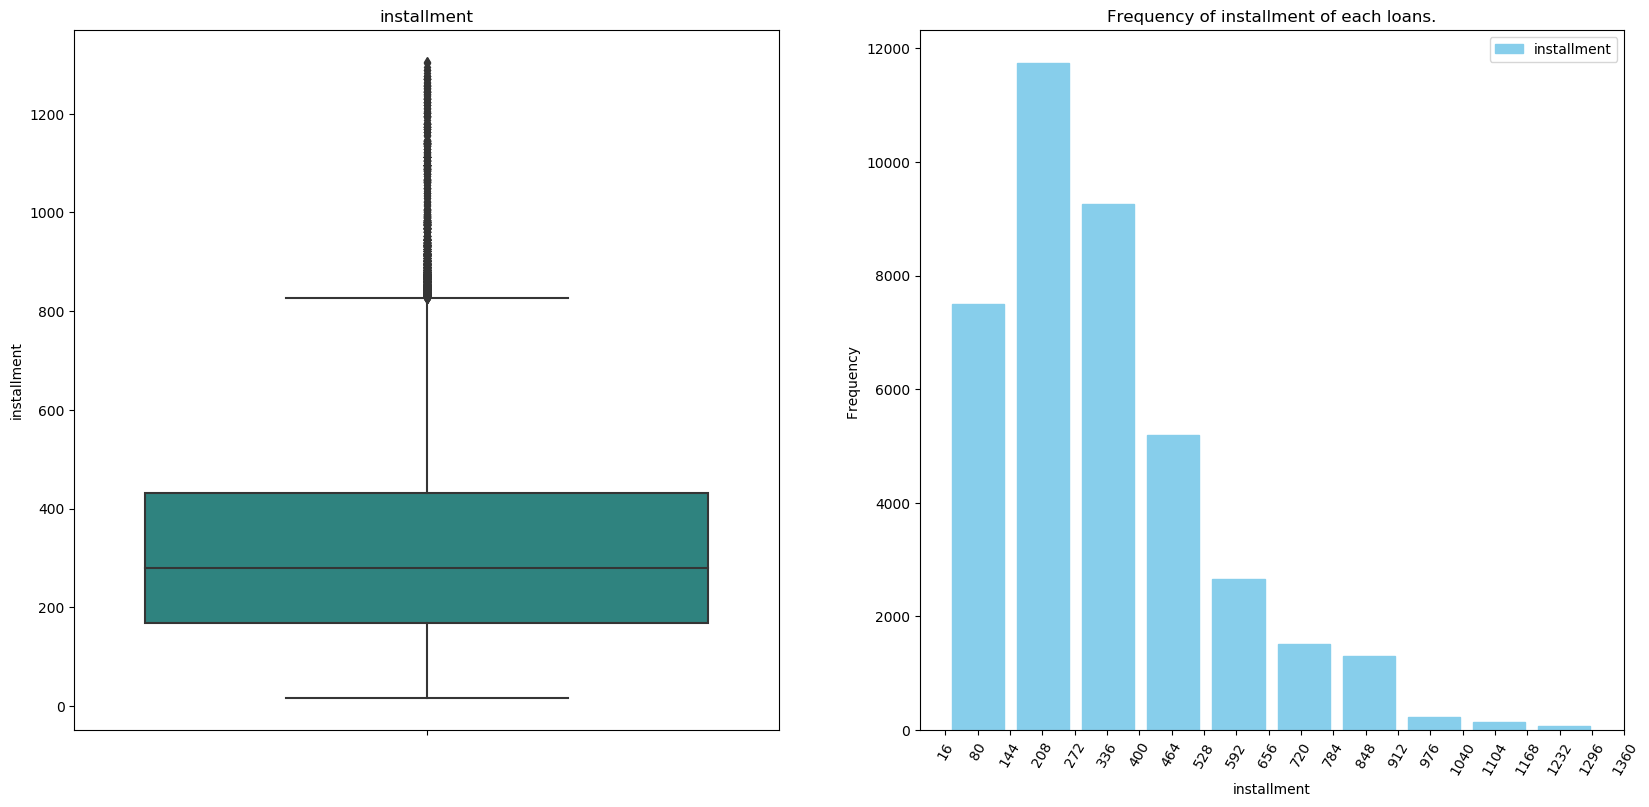

In [109]:
# Draw a plot to see how column "installment" is distributed
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=loandf['installment'], palette='viridis')
plt.ylabel('installment')
plt.title('installment')

# Chart to depict the frequency of installment of each loan
installment = loandf['installment']
legend = ['installment']
plt.subplot(2,2,2)
plt.hist([installment], color = "skyblue", ec="skyblue", bins=10, rwidth=0.80)
plt.xlabel("installment")
plt.ylabel("Frequency ")
plt.legend(legend)
plt.xticks(np.arange(min(installment), max(installment)+64, 64), rotation=60)
plt.title('Frequency of installment of each loans.')
plt.show()

C:\Users\hp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


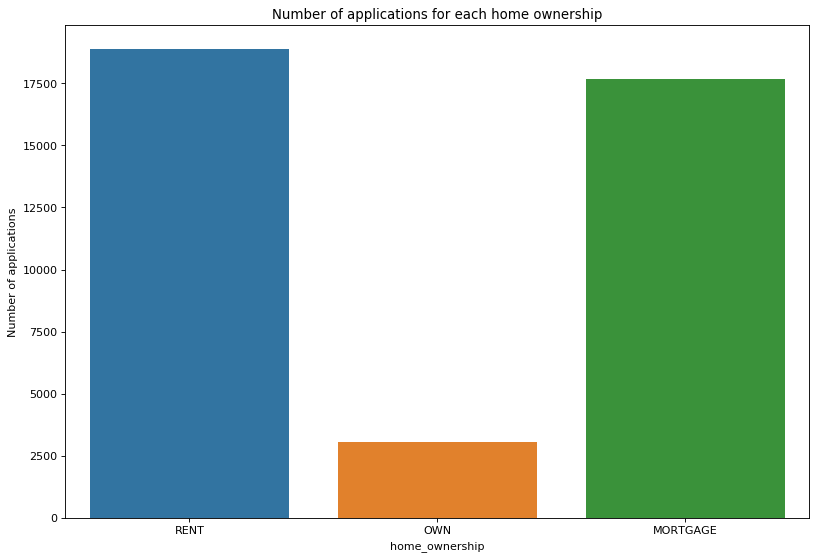

In [110]:
#Plotting Number of applications for each home ownership
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

# specify hue="categorical_variable"
sns.barplot(x='home_ownership', y = 'member_id', data=loandf, estimator=len)
plt.title("Number of applications for each home ownership")
plt.ylabel("Number of applications")
plt.show()

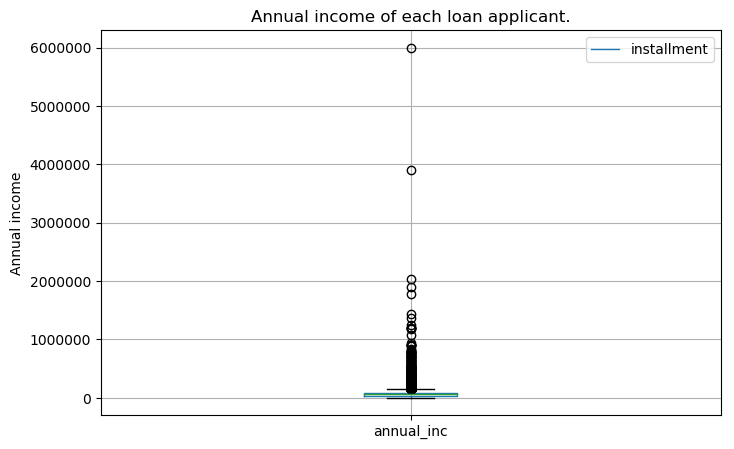

mode of Annual income: 60000.0

 Plot after removing outliers:



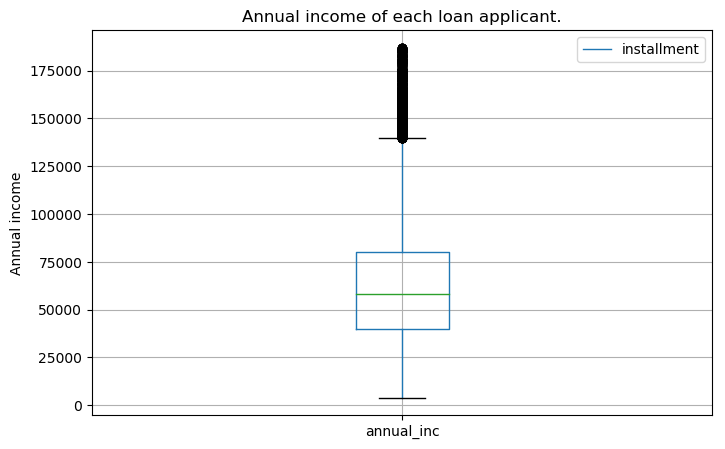

Distribution of Annual Income & the Frequency Chart


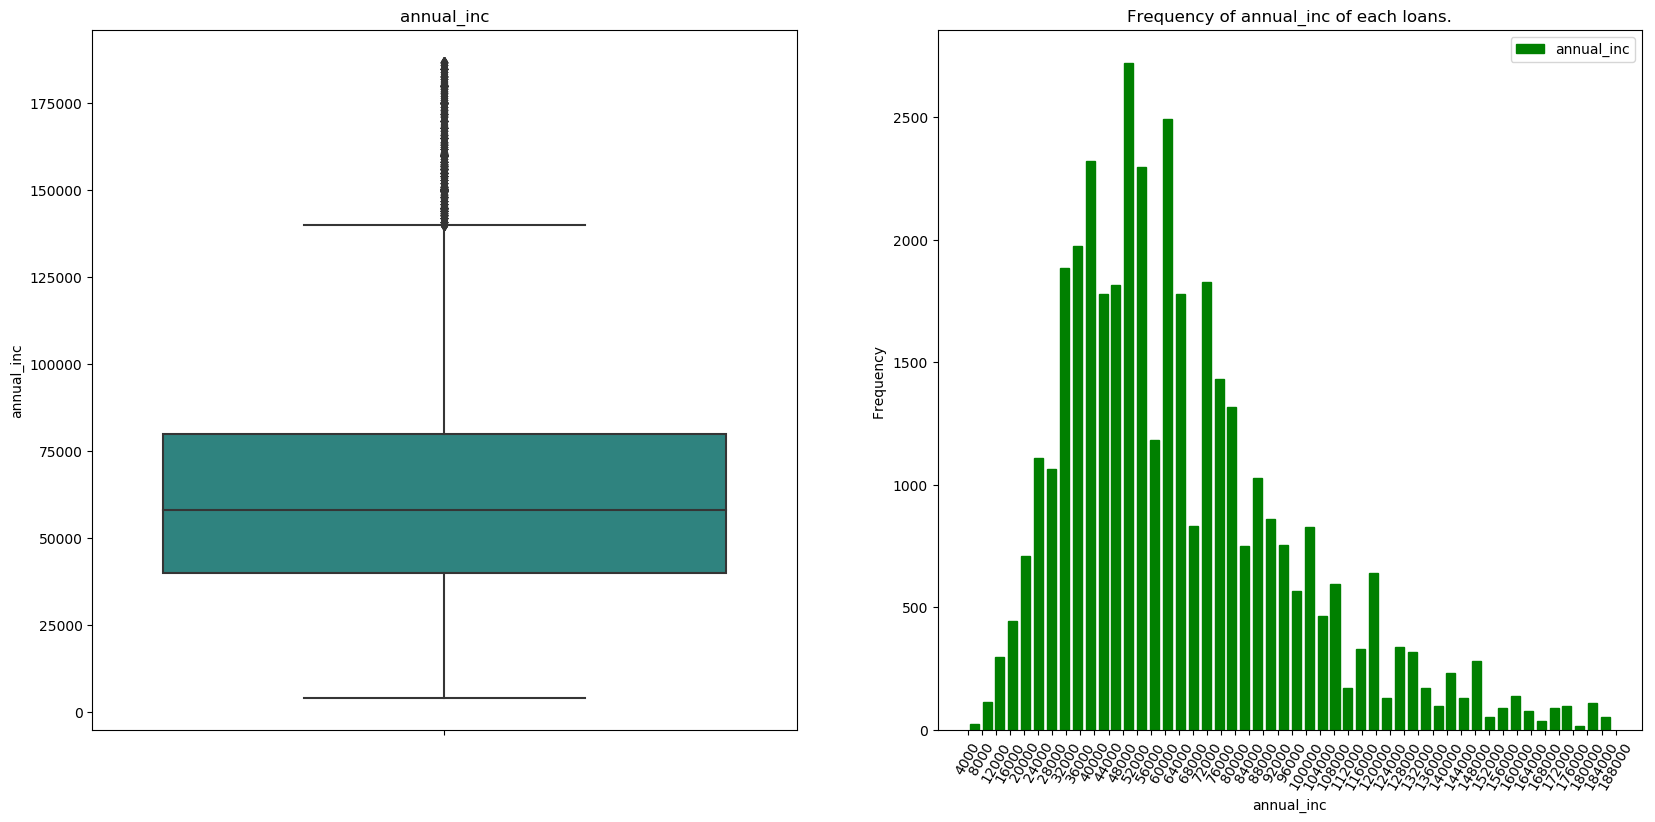

In [111]:
# Plot for the column  of annual_inc to visualise their distribution
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(8,5))
loandf.boxplot(column='annual_inc')
plt.ylabel('Annual income')
plt.legend(legend)
plt.title('Annual income of each loan applicant.')
plt.show()

annual_inc_mode = loandf['annual_inc'].mode()
print("mode of Annual income:", annual_inc_mode.values[0])

#Observations:
# 1. there are clear outliers in the annul income, we need to remove these outliers for the accurate analysis.

# Lets remove the outliers
loandf = loandf[loandf.annual_inc <=loandf.annual_inc.quantile(.98)]

# Lets draw the plot again, after removing the outliers.
print("\n Plot after removing outliers:\n")
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(8,5))
loandf.boxplot(column='annual_inc')
plt.ylabel('Annual income')
plt.legend(legend)
plt.title('Annual income of each loan applicant.')
plt.show()

# now see the distribution
print("Distribution of Annual Income & the Frequency Chart")
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=loandf['annual_inc'], palette='viridis')
plt.ylabel('annual_inc')
plt.title('annual_inc')

#Frequency Chart
annual_inc = loandf['annual_inc']
legend = ['annual_inc']
plt.subplot(2,2,2)
plt.hist([annual_inc], color = "green", ec="green", bins=50, rwidth=0.70)
plt.xlabel("annual_inc")
plt.ylabel("Frequency ")
plt.legend(legend)
plt.xticks(np.arange(min(annual_inc), max(annual_inc)+4000, 4000), rotation=60)
plt.title('Frequency of annual_inc of each loans.')
plt.show()

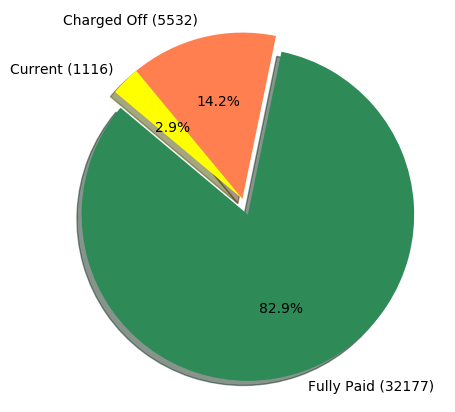

In [112]:
# loan_status analysis
loan_status = pd.DataFrame(loandf['loan_status'].value_counts())

# Data's to plot
chart_label_loan_status = ["Fully Paid (" + str(loan_status.loc['Fully Paid'].values[0]) + ')',
                           "Charged Off (" + str(loan_status.loc['Charged Off'].values[0]) + ')',
                           "Current (" + str(loan_status.loc['Current'].values[0]) + ')']

colors = ['seagreen', 'coral', 'yellow']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(5, 5))
plt.pie(loan_status, explode=explode, labels=chart_label_loan_status, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Observation:
# Most of the loans are fully paid, only few loans are in processing stage

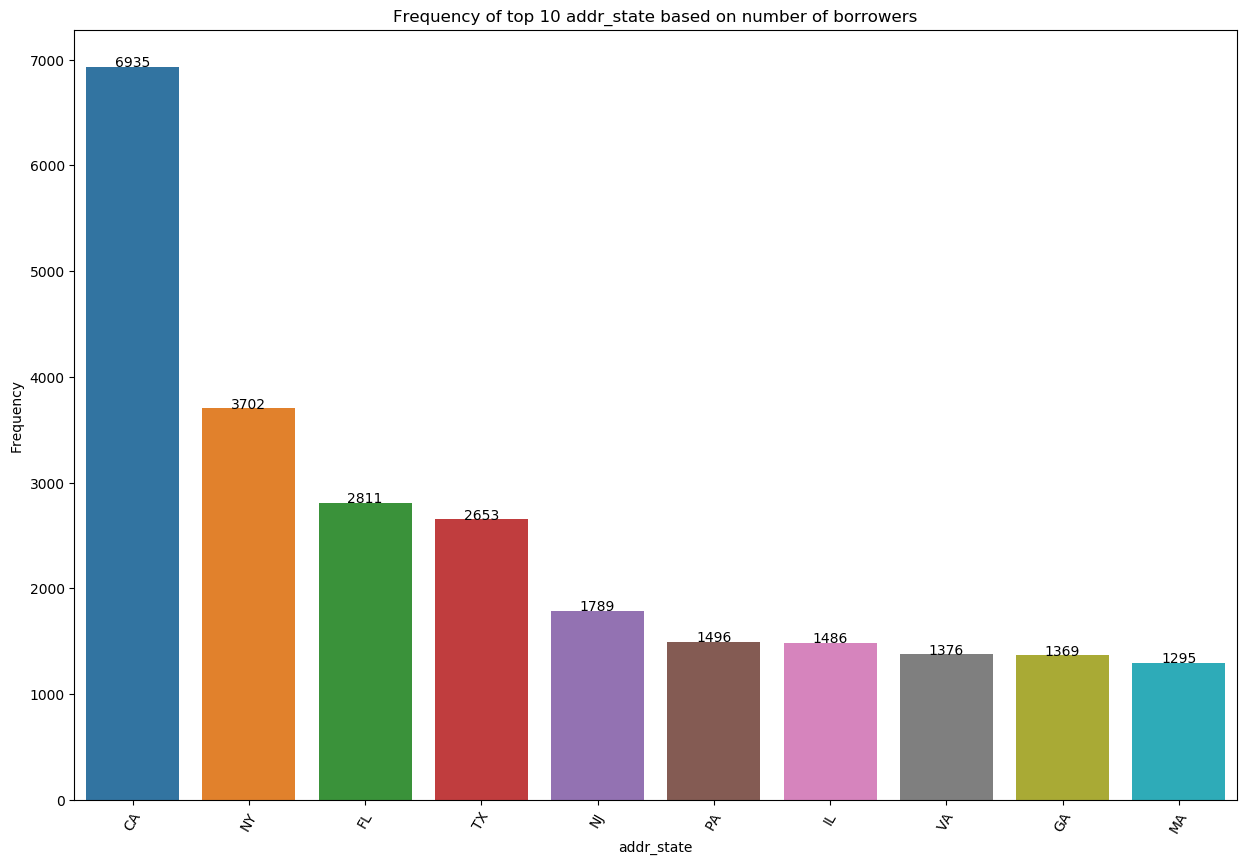

Observation:
	Maximum number of borrowers are from State CA



In [113]:
# addr_state distribution
#Frequency Chart 
plt.figure(figsize=(15, 10))
# Restore the rc params from Matplotlib’s internal defaults.
plt.rcdefaults() 
#Plotting top 10 addr_state based on borrowers whom loan is given
addr_state_values = pd.DataFrame(loandf['addr_state'].value_counts())[:10]

ax = sns.barplot(x=addr_state_values.index, y="addr_state", data=addr_state_values)
show_values_on_bars(ax)
plt.xlabel("addr_state")
plt.ylabel("Frequency")
plt.title('Frequency of top 10 addr_state based on number of borrowers')
plt.xticks(rotation=60)
plt.show()
print('Observation:\n\tMaximum number of borrowers are from State CA\n')

# Derived Metrics

In [114]:
# Create new variable for Default Status
loandf.loc[loandf['loan_status'] == 'Charged Off', 'loan_status_modf'] = 'Default' ## Default 
loandf.loc[loandf['loan_status'] == 'Current', 'loan_status_modf'] = 'Good' ## Non Default
loandf.loc[loandf['loan_status'] == 'Fully Paid', 'loan_status_modf'] = 'Good' ## Non Default
loandf.head()

,member_id,loan_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,open_acc,pub_rec,revol_util,loan_status_modf
0,1296599,5000,4975.0,36,10.65,162.87,B2,10.0,RENT,24000.0,...,Fully Paid,credit_card,860xx,AZ,27.65,0,3,0,83.7,Good
1,1314167,2500,2500.0,60,15.27,59.83,C4,0.0,RENT,30000.0,...,Charged Off,car,309xx,GA,1.00,0,3,0,9.4,Default
2,1313524,2400,2400.0,36,15.96,84.33,C5,10.0,RENT,12252.0,...,Fully Paid,small_business,606xx,IL,8.72,0,2,0,98.5,Good
3,1277178,10000,10000.0,36,13.49,339.31,C1,10.0,RENT,49200.0,...,Fully Paid,other,917xx,CA,20.00,0,10,0,21.0,Good
4,1311748,3000,3000.0,60,12.69,67.79,B5,1.0,RENT,80000.0,...,Current,other,972xx,OR,17.94,0,15,0,53.9,Good


In [115]:
# Define a new cloumn install_incm_per 
loandf['install_incm_per'] = ((loandf['installment'])/(loandf['annual_inc']/12))*100

In [116]:
# Define a bracket for interested rate and see how each bracket is performing against loan status
loandf['interest_rate_bracket'] = loandf['int_rate'].apply(lambda x :'0-5' if x <=5 else ('5-10' if x<=10 else ('10-15' if x <=15 else ('15-20' if x<=20 else('20-25' if x <=25 else '25+')))))
loandf[['int_rate','interest_rate_bracket']].head(10)

,int_rate,interest_rate_bracket
0,10.65,10-15
1,15.27,15-20
2,15.96,15-20
3,13.49,10-15
4,12.69,10-15
5,7.90,5-10
6,15.96,15-20
7,18.64,15-20
8,21.28,20-25
9,12.69,10-15


### Segmented Univariate Analysis

##### Segmented Analysis of state wise loan_status 

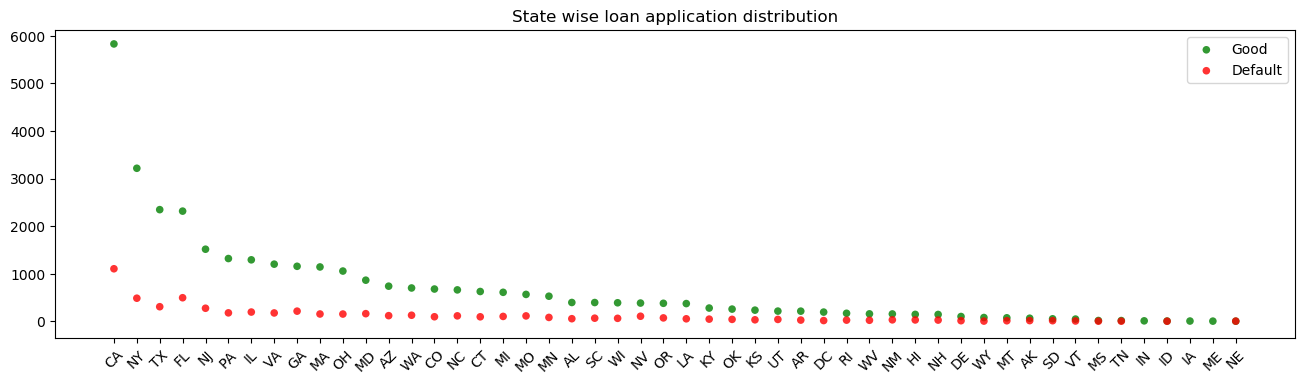

In [117]:
# Lets do segmented analysis using columns addr_state and loan_status.
# Create data
good_loan_df = pd.DataFrame(loandf[loandf.loan_status_modf == 'Good']['addr_state'].value_counts())
default_loan_df = pd.DataFrame(loandf[loandf.loan_status_modf == 'Default']['addr_state'].value_counts())
 
data = (good_loan_df, default_loan_df)
colors = ("green", "red")
groups = ("Good", "Default") 
 
# Create plot
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")

for data, color, group in zip(data, colors, groups):
    x = data.index
    y = data.addr_state
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
    
plt.title('State wise loan application distribution')
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.show()

# Observation:
# 1. State CA has maximum number of loan applications
# 2. CA has maximum no. of defaulters
# 3. CA has maximum no. of fully paid loans

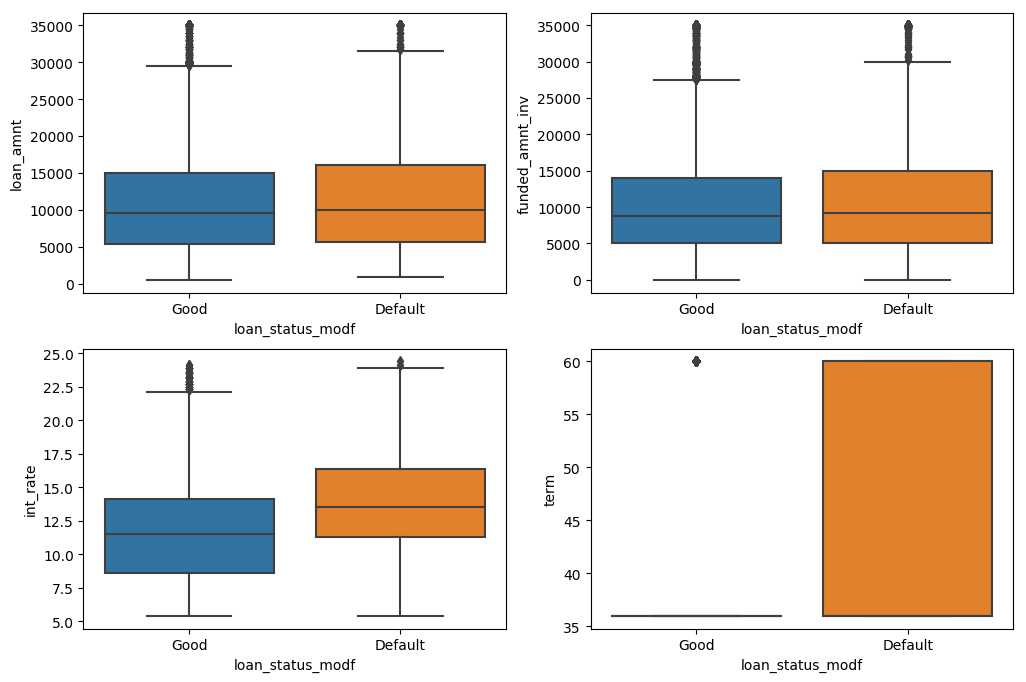

In [118]:
# Segmented analysis on loan status for loan amount, funded amount and int rate.
plt.rcdefaults()
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x="loan_status_modf", y="loan_amnt", data=loandf)

plt.subplot(2, 2, 2)
sns.boxplot(x="loan_status_modf",  y="funded_amnt_inv", data=loandf)

plt.subplot(2, 2, 3)
sns.boxplot(x="loan_status_modf", y="int_rate", data=loandf)\

plt.subplot(2, 2, 4)
sns.boxplot(x="loan_status_modf", y="term", data=loandf)

plt.show()


# Observations:
# 1. loan_amnt and funded_amnt_inv has almost equal spread and median for Good and Defaulted loans
# 2. Interest rates for defaulted loans are higher than Good loans
# 3. There is a clear pattern of Defaulted loans, all have 60 months term
# Conclusion: 60 months term loans and higher interest loans are high risk loans with maximum chances of defaulting.

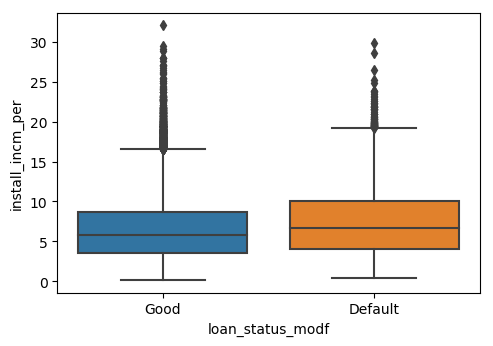

In [119]:
# Segmented univariate for install_incm_per for each loan_default_status
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x="loan_status_modf", y="install_incm_per", data=loandf)


plt.show()


# Observation:
# 1. Installment to Income Percentage is slightly higher for defaulted loans.

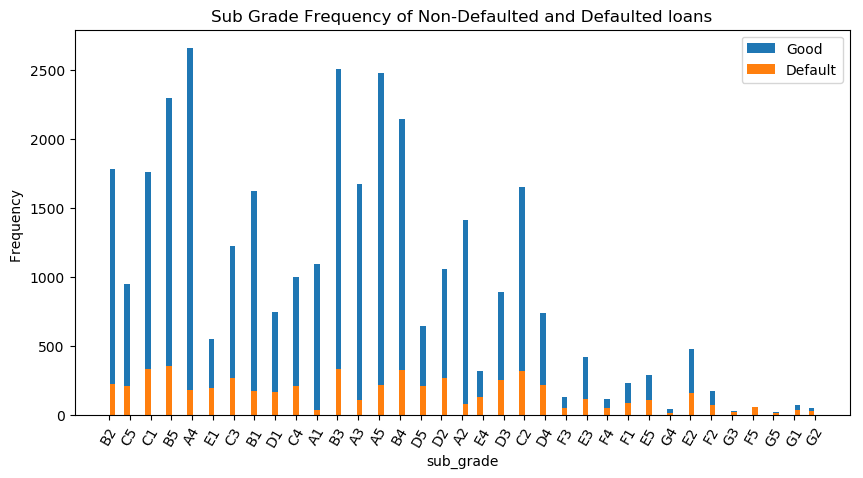

In [120]:
# Segmented Analysis of sub grade
# Frequency Chart
sub_grade_fp = loandf[loandf.loan_status_modf == 'Good'].sub_grade
sub_grade_co = loandf[loandf.loan_status_modf == 'Default'].sub_grade

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(10,5))

plt.hist([sub_grade_fp], bins=100, rwidth=0.80)
plt.hist([sub_grade_co], bins=100, rwidth=0.80)

plt.xlabel("sub_grade")
plt.ylabel("Frequency ")

plt.legend(loandf.loan_status_modf)
plt.xticks(rotation=60)

plt.title('Sub Grade Frequency of Non-Defaulted and Defaulted loans')
plt.show()

# Observations:
# 1. lower sub_grade has higher chances of defaulting the loan

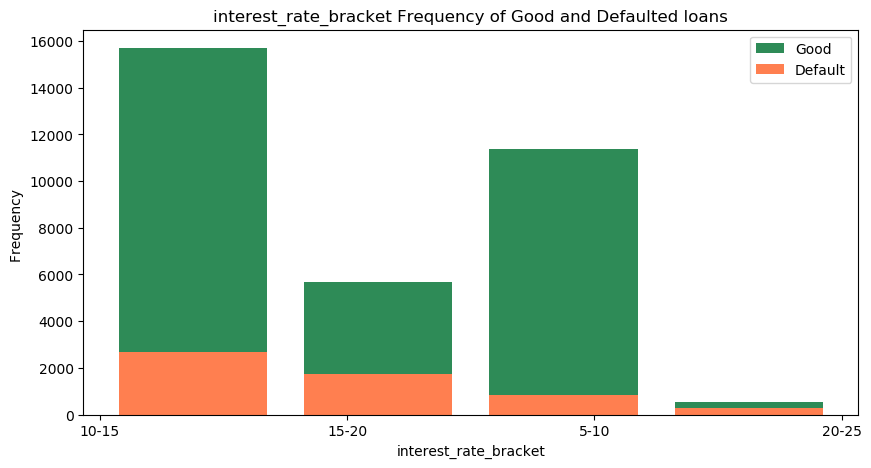

In [121]:
# Segmented univariate for interest_rate_bracket for each loan_status_modf

# Frequency Chart
emp_length_fp = loandf[loandf.loan_status_modf == 'Good']['interest_rate_bracket']
emp_length_co = loandf[loandf.loan_status_modf == 'Default']['interest_rate_bracket']

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(10, 5))

plt.hist([emp_length_fp], bins=4, rwidth=0.80, color='seagreen')
plt.hist([emp_length_co], bins=4, rwidth=0.80, color='coral')

plt.xlabel("interest_rate_bracket")
plt.ylabel("Frequency ")

plt.legend(loandf.loan_status_modf, loc='upper right')

plt.title('interest_rate_bracket Frequency of Good and Defaulted loans')
plt.show()

# Observations:
# Approx 35% loans in the interest bracket 20-25% have been defaulted.
# Approx 24% loans in 15-20% interest bracket have defaulted

##### Segmented analysis of employment length 

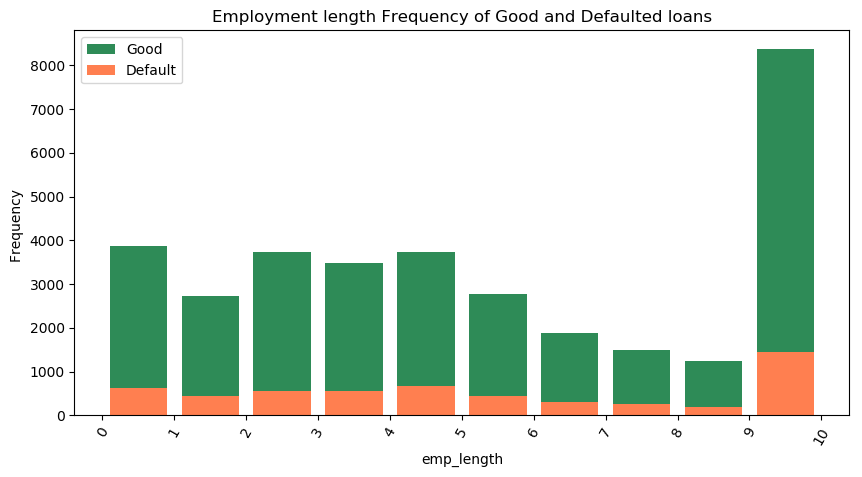

In [122]:
# Segmented analysis of employment length
# Frequency Chart
emp_length_gd = loandf[loandf.loan_status_modf == 'Good']['emp_length']
emp_length_df = loandf[loandf.loan_status_modf == 'Default']['emp_length']

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(10, 5))

plt.hist([emp_length_gd], bins=10, rwidth=0.80, color='seagreen')
plt.hist([emp_length_df], bins=10, rwidth=0.80, color='coral')

plt.xlabel("emp_length")
plt.ylabel("Frequency ")

plt.legend(loandf.loan_status_modf, loc='upper left')
plt.xticks(np.arange(min(emp_length_df), max(emp_length_df)+1, 1), rotation=60)
plt.title('Employment length Frequency of Good and Defaulted loans')
plt.show()

# Observations:
# 1. Borrower's with low experience have higher default %.

###### Segmented Analysis of Verification status

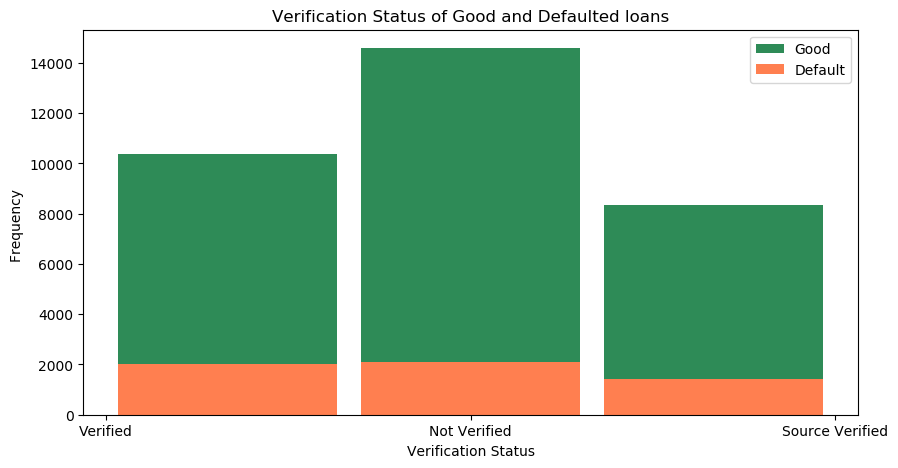

In [123]:
verification_status_gd = loandf[loandf.loan_status_modf == 'Good'].verification_status
verification_status_df = loandf[loandf.loan_status_modf == 'Default'].verification_status

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(10,5))

plt.hist([verification_status_gd], bins=verification_status_gd.nunique(), rwidth=0.90, color='seagreen')
plt.hist([verification_status_df], bins=verification_status_df.nunique(), rwidth=0.90, color='coral')

plt.xlabel("Verification Status")
plt.ylabel("Frequency ")

plt.legend(loandf.loan_status_modf)
plt.xticks()

plt.title('Verification Status of Good and Defaulted loans')
plt.show()

# Observations: 
# 1. Maximum percentage of loans sanctioned in "Verified" category have been defaulted. 
# 2. Not Verified have the least % of defaulted loans

###### Segmented analysis of term

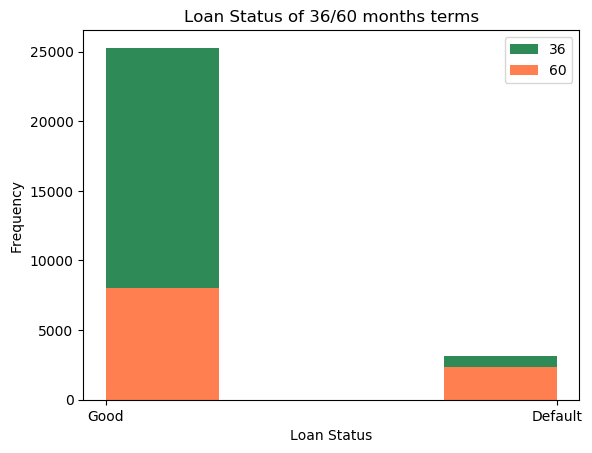

In [124]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.

fp = loandf[loandf.term == 36].loan_status_modf
co = loandf[loandf.term == 60].loan_status_modf

plt.hist([fp], bins=fp.nunique()+2, color='seagreen')
plt.hist([co], bins=co.nunique()+2, color='coral')

plt.xlabel("Loan Status")
plt.ylabel("Frequency")

plt.legend(loandf.term)
plt.xticks()

plt.title('Loan Status of 36/60 months terms')
plt.show()

# Observation : loans with 60 months term have more chances of defaulting.

# Bivariate Analysis

In [125]:
#Bivariate Coorelation Matrix
corr = round(loandf.corr(),2)
corr.style.background_gradient()

# Observations:
# strong correlation between fields loan_amount, installment and funded_amnt_inv, but this strong correlation is obvious

,member_id,loan_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,revol_util,install_incm_per
member_id,1,0.14,0.26,0.23,0.07,0.08,0.12,0.04,0.1,-0.01,0.02,-0.02,0.09,0.03
loan_amnt,0.14,1,0.94,0.36,0.3,0.93,0.15,0.42,0.08,-0.04,0.17,-0.05,0.07,0.55
funded_amnt_inv,0.26,0.94,1,0.36,0.3,0.9,0.16,0.4,0.09,-0.04,0.16,-0.05,0.08,0.53
term,0.23,0.36,0.36,1,0.45,0.1,0.11,0.08,0.08,0.01,0.05,0.01,0.07,0.02
int_rate,0.07,0.3,0.3,0.45,1,0.28,0.01,0.07,0.11,0.16,0,0.1,0.47,0.19
installment,0.08,0.93,0.9,0.1,0.28,1,0.12,0.41,0.07,-0.02,0.17,-0.04,0.1,0.61
emp_length,0.12,0.15,0.16,0.11,0.01,0.12,1,0.18,0.06,0.01,0.1,0.06,0.01,-0.03
annual_inc,0.04,0.42,0.4,0.08,0.07,0.41,0.18,1,-0.1,0.03,0.26,-0.02,0.04,-0.33
dti,0.1,0.08,0.09,0.08,0.11,0.07,0.06,-0.1,1,-0.03,0.29,-0.01,0.28,0.12
delinq_2yrs,-0.01,-0.04,-0.04,0.01,0.16,-0.02,0.01,0.03,-0.03,1,0.01,0.01,-0.04,-0.05


## Bivariate analysis on continuous variables

In [126]:
# Create 2 data frame one for Non-Defaulter and another for Defaulter
fully_paid_df = pd.DataFrame(loandf[loandf.loan_status_modf == 'Good']).reset_index()
default_df = pd.DataFrame(loandf[loandf.loan_status_modf == 'Default']).reset_index()

C:\Users\hp\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


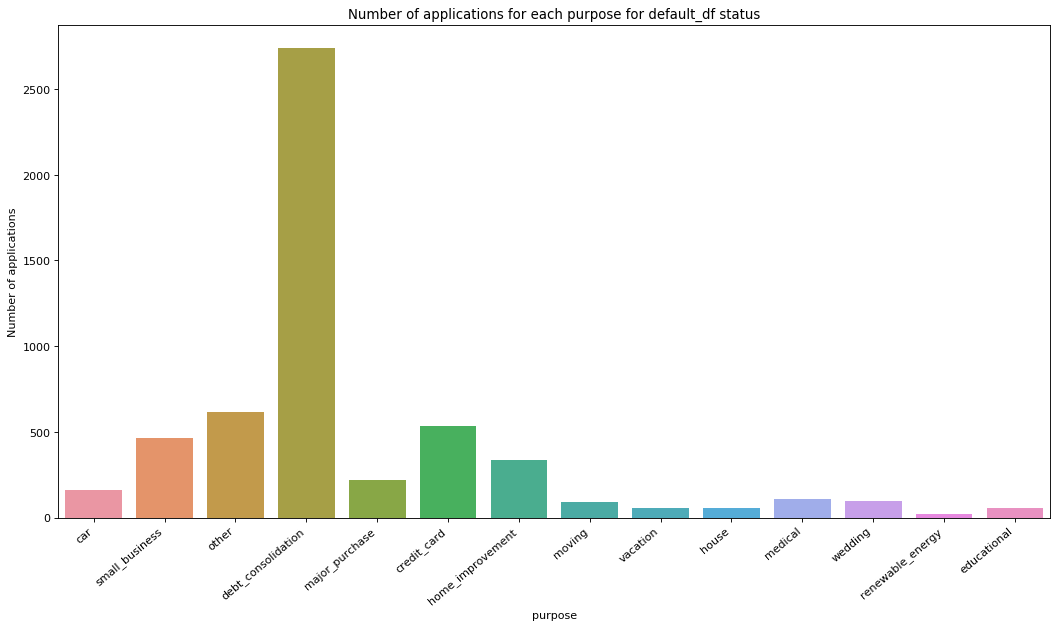

In [127]:
#Plotting Number of applications for each purpose
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

# specify hue="categorical_variable"
bt = sns.barplot(x='purpose', y='member_id',data=default_df, estimator=len)
bt.set_xticklabels(bt.get_xticklabels(), rotation=40, ha="right")
plt.title("Number of applications for each purpose for default_df status")
plt.ylabel("Number of applications")
plt.show()

##### Correlation of Loan amount and funded amount of Defaulted loans

The correlation of loan amount and funded amount is  0.91

Line plot showing loan amnt and funded amnt from invester.



<Figure size 2000x2500 with 0 Axes>

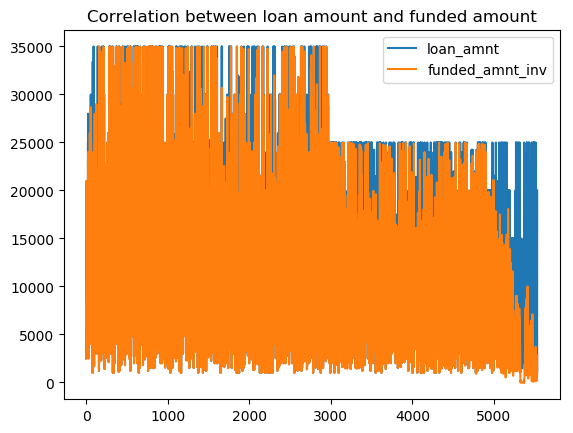


Correlation plot of loan amount and funded amount.

                 loan_amnt  funded_amnt_inv
loan_amnt         1.000000         0.908225
funded_amnt_inv   0.908225         1.000000


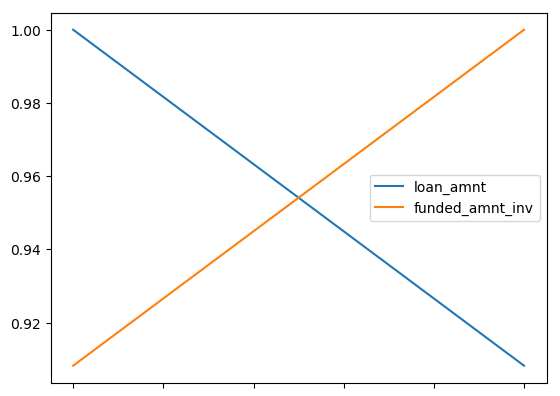

The loan amont and funded amount has higher corelation coeffeciant in the case of Defaulted loans.


In [128]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20, 25))

loan_fund_amnt = pd.DataFrame({'loan_amnt': default_df['loan_amnt'], 'funded_amnt_inv': default_df['funded_amnt_inv']})
corrcoefficiant = pearsonr(loan_fund_amnt['loan_amnt'], loan_fund_amnt['funded_amnt_inv'])
print("The correlation of loan amount and funded amount is ",
      round(corrcoefficiant[0], 2))

print("\nLine plot showing loan amnt and funded amnt from invester.\n")
loan_fund_amnt.plot(kind='line', subplots=False)
plt.title('Correlation between loan amount and funded amount')
plt.show()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

print("\nCorrelation plot of loan amount and funded amount.\n")
corr = loan_fund_amnt.corr()
print(corr)
corr.plot(kind='line', subplots=False)
plt.show()

print('The loan amont and funded amount has higher corelation coeffeciant in the case of Defaulted loans.')

##### Correlation of Loan amount and funded amount of Non-Defaulted loans

The correlation of loan amount and funded amount is  0.95

Line plot showing loan amnt and funded amnt from invester.



<Figure size 2000x2500 with 0 Axes>

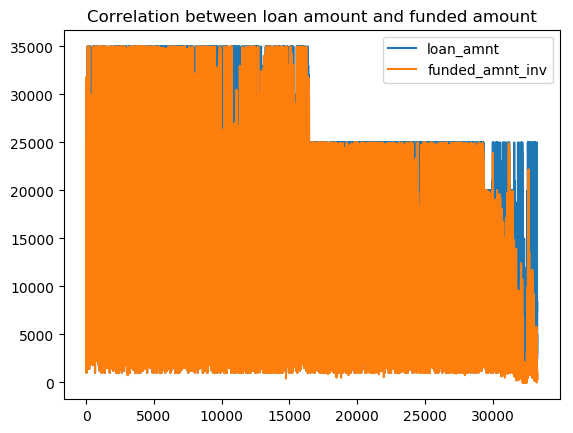


Correlation plot of loan amount and funded amount.

                 loan_amnt  funded_amnt_inv
loan_amnt         1.000000         0.946833
funded_amnt_inv   0.946833         1.000000


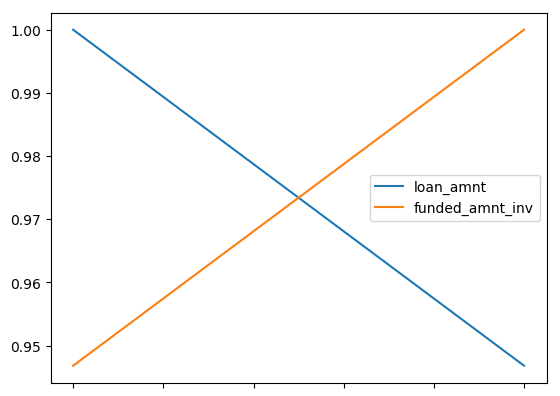

Observation:
The loan amont and funded amount has higher corelation coeffeciant in the case of Good loans.


In [129]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(20, 25))

loan_fund_amnt = pd.DataFrame({'loan_amnt': fully_paid_df['loan_amnt'], 'funded_amnt_inv': fully_paid_df['funded_amnt_inv']})
corrcoefficiant = pearsonr(loan_fund_amnt['loan_amnt'], loan_fund_amnt['funded_amnt_inv'])
print("The correlation of loan amount and funded amount is ",
      round(corrcoefficiant[0], 2))

print("\nLine plot showing loan amnt and funded amnt from invester.\n")
loan_fund_amnt.plot(kind='line', subplots=False)
plt.title('Correlation between loan amount and funded amount')
plt.show()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

print("\nCorrelation plot of loan amount and funded amount.\n")
corr = loan_fund_amnt.corr()
print(corr)
corr.plot(kind='line', subplots=False)
plt.show()

print('Observation:\nThe loan amont and funded amount has higher corelation coeffeciant in the case of Good loans.')

## Bivariate analysis on categorical variables

##### Analysis of year and loan status

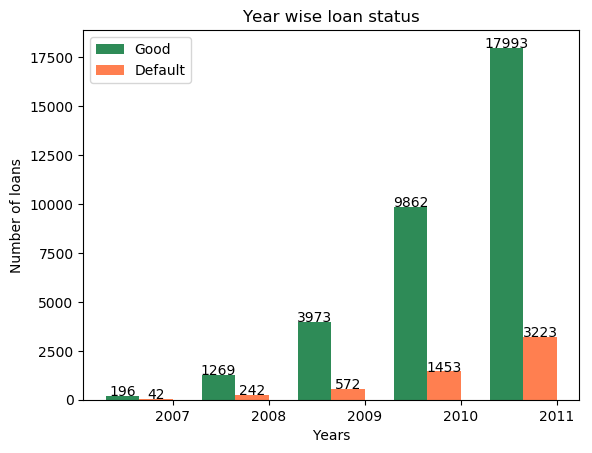

Observation:
	Year 2011 has most loans on both catagories.


In [130]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.

issue_d_fp = fully_paid_df.groupby(fully_paid_df.issue_d.dt.year).size()
issue_d_co = default_df.groupby(default_df.issue_d.dt.year).size()

ind = np.arange(max(len(issue_d_fp), len(issue_d_co)))  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ind-width,issue_d_fp,width,color='seagreen',label='Good')
ax.bar(ind,issue_d_co,width,color='coral',label='Default')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( (issue_d_fp.index) )
show_values_on_bars(ax)
plt.xlabel('Years')
plt.ylabel('Number of loans')
plt.title('Year wise loan status')
plt.legend()

plt.show()

print('Observation:\n\tYear 2011 has most loans on both catagories.')

###### Analysis of Verification Status and Loan Status

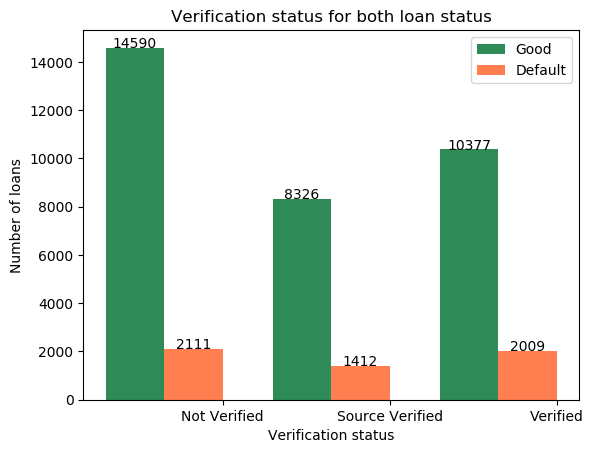

In [131]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.

verification_status_fp = fully_paid_df.groupby(fully_paid_df.verification_status).size()
verification_status_co = default_df.groupby(default_df.verification_status).size()

ind = np.arange(max(len(verification_status_fp), len(verification_status_co)))  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ind-width, verification_status_fp, width, color='seagreen', label='Good')
ax.bar(ind, verification_status_co, width, color='coral', label='Default')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( (verification_status_fp.index) )
show_values_on_bars(ax)
plt.xlabel('Verification status')
plt.ylabel('Number of loans')
plt.title('Verification status for both loan status')
plt.legend()

plt.show()


##### Analysis of Sub Grade and loan status

<Figure size 20000x2500 with 0 Axes>

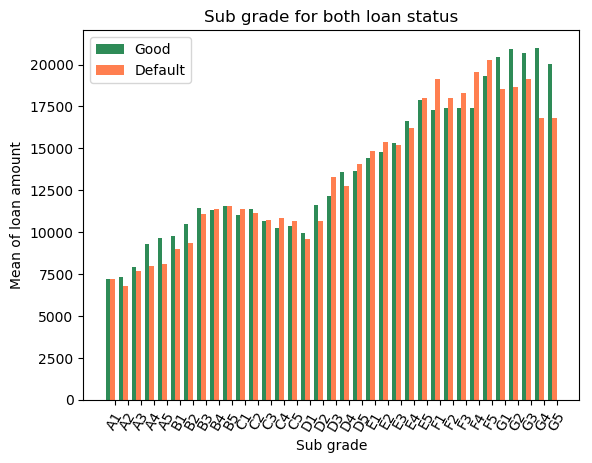

Observation:
	Lower the grade higher is the average loan amount and risk for defaulting.


In [132]:
# grouby(grade,loan_status) take average  of loan_amount

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(200,25))

g1 = fully_paid_df.groupby(fully_paid_df.sub_grade).loan_amnt.mean()
g2 = default_df.groupby(default_df.sub_grade).loan_amnt.mean()

xlabel = 'Sub grade'
ylabel = 'Mean of loan amount'
title = 'Sub grade for both loan status'

ind = np.arange(max(len(g1), len(g2)))  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(ind-width, g1, width, color='seagreen', label='Good')
ax.bar(ind, g2, width, color='coral', label='Default')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels( (g1.index) )

plt.xticks(rotation=60)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend()

plt.show()

print('Observation:\n\tLower the grade higher is the average loan amount and risk for defaulting.')

###### Analysis of Employment duration and loan status

<Figure size 20000x2500 with 0 Axes>

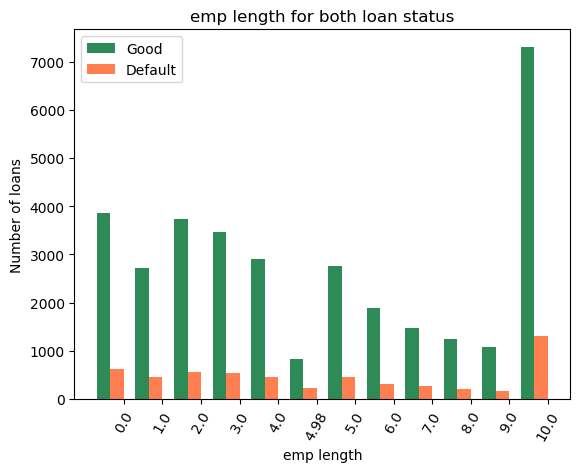

Observations:
	Borrowers with more experience require more loans in both the catagories
	No Clear pattern of loan defaulting based on borrowers experience.


In [133]:
# grouby(emp_length,loan_status) take average  of loan_amount

plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(200,25))

g1 = round(fully_paid_df.groupby(fully_paid_df.emp_length).size())
g2 = round(default_df.groupby(default_df.emp_length).size())

xlabel = 'emp length'
ylabel = 'Number of loans'
title = 'emp length for both loan status'

ind = np.arange(max(len(g1), len(g2)))  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(ind-width, g1, width, color='seagreen', label='Good')
ax.bar(ind, g2, width, color='coral', label='Default')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels( (g1.index) )

plt.xticks(rotation=60)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.legend()

plt.show()

print('Observations:\n\tBorrower''s with more experience require more loans in both the catagories')
print('\tNo Clear pattern of loan defaulting based on borrower''s experience.')

###### Analysis of state, purpose and loan status

In [134]:
# Groupby(State, purpose, loan_status) : Take count of loan_status
# Create pivot table
default_df["purpose"] = default_df["purpose"].astype("category")
default_pvt_df = pd.pivot_table(default_df, index=["purpose"], values="loan_status", columns="addr_state", aggfunc=[len])
default_pvt_df.columns = default_pvt_df.columns.droplevel(0)
default_pvt_df

addr_state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
purpose,,,,,,,,,,,,,,,,,,,,,
car,NaN,1.0,3.0,4.0,26.0,2.0,3.0,NaN,NaN,16.0,...,NaN,NaN,11.0,1.0,4.0,NaN,4.0,1.0,NaN,NaN
credit_card,3.0,7.0,2.0,17.0,137.0,9.0,10.0,4.0,3.0,44.0,...,3.0,1.0,24.0,3.0,11.0,1.0,17.0,8.0,3.0,1.0
debt_consolidation,7.0,25.0,9.0,55.0,545.0,52.0,50.0,7.0,2.0,232.0,...,6.0,1.0,135.0,15.0,89.0,5.0,66.0,33.0,9.0,1.0
educational,NaN,1.0,1.0,3.0,10.0,2.0,NaN,NaN,NaN,9.0,...,NaN,NaN,5.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
home_improvement,NaN,6.0,2.0,2.0,57.0,6.0,9.0,NaN,NaN,37.0,...,NaN,NaN,18.0,2.0,12.0,NaN,3.0,2.0,1.0,1.0
house,NaN,NaN,NaN,2.0,14.0,1.0,1.0,NaN,NaN,7.0,...,NaN,NaN,4.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN
major_purchase,NaN,3.0,NaN,6.0,34.0,2.0,5.0,NaN,NaN,30.0,...,NaN,NaN,17.0,NaN,3.0,NaN,4.0,3.0,1.0,NaN
medical,1.0,1.0,1.0,1.0,17.0,1.0,1.0,NaN,NaN,9.0,...,NaN,NaN,6.0,NaN,4.0,NaN,3.0,1.0,1.0,NaN
moving,NaN,1.0,NaN,2.0,22.0,NaN,NaN,1.0,NaN,4.0,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN


In [135]:
# 2nd pivot table
fully_paid_df["purpose"] = fully_paid_df["purpose"].astype("category")
fully_paid_pvt_df = pd.pivot_table(fully_paid_df, index=["purpose"], values="loan_status", columns="addr_state", aggfunc=[len])
fully_paid_pvt_df.columns = fully_paid_pvt_df.columns.droplevel(0)
fully_paid_pvt_df

addr_state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
purpose,,,,,,,,,,,,,,,,,,,,,
car,1.0,21.0,14.0,31.0,198.0,28.0,30.0,4.0,5.0,98.0,...,2.0,1.0,105.0,11.0,57.0,1.0,28.0,22.0,8.0,4.0
credit_card,8.0,42.0,26.0,110.0,892.0,118.0,75.0,35.0,11.0,291.0,...,10.0,2.0,344.0,35.0,160.0,6.0,101.0,66.0,19.0,7.0
debt_consolidation,26.0,199.0,95.0,302.0,2849.0,323.0,289.0,103.0,42.0,1021.0,...,22.0,3.0,1022.0,104.0,590.0,21.0,331.0,173.0,85.0,36.0
educational,NaN,3.0,1.0,4.0,34.0,6.0,4.0,NaN,NaN,19.0,...,NaN,1.0,10.0,2.0,5.0,NaN,7.0,2.0,NaN,NaN
home_improvement,10.0,34.0,21.0,63.0,316.0,35.0,56.0,8.0,15.0,207.0,...,3.0,1.0,191.0,17.0,96.0,3.0,52.0,34.0,8.0,3.0
house,NaN,6.0,1.0,10.0,48.0,11.0,5.0,2.0,1.0,37.0,...,1.0,NaN,15.0,2.0,12.0,NaN,6.0,5.0,NaN,1.0
major_purchase,3.0,26.0,21.0,45.0,282.0,34.0,44.0,8.0,5.0,142.0,...,2.0,2.0,142.0,5.0,61.0,4.0,34.0,23.0,12.0,13.0
medical,2.0,3.0,5.0,18.0,114.0,16.0,8.0,1.0,1.0,40.0,...,NaN,NaN,56.0,9.0,11.0,1.0,11.0,3.0,2.0,2.0
moving,NaN,3.0,NaN,17.0,85.0,13.0,8.0,4.0,2.0,39.0,...,NaN,NaN,29.0,1.0,21.0,1.0,6.0,5.0,2.0,NaN


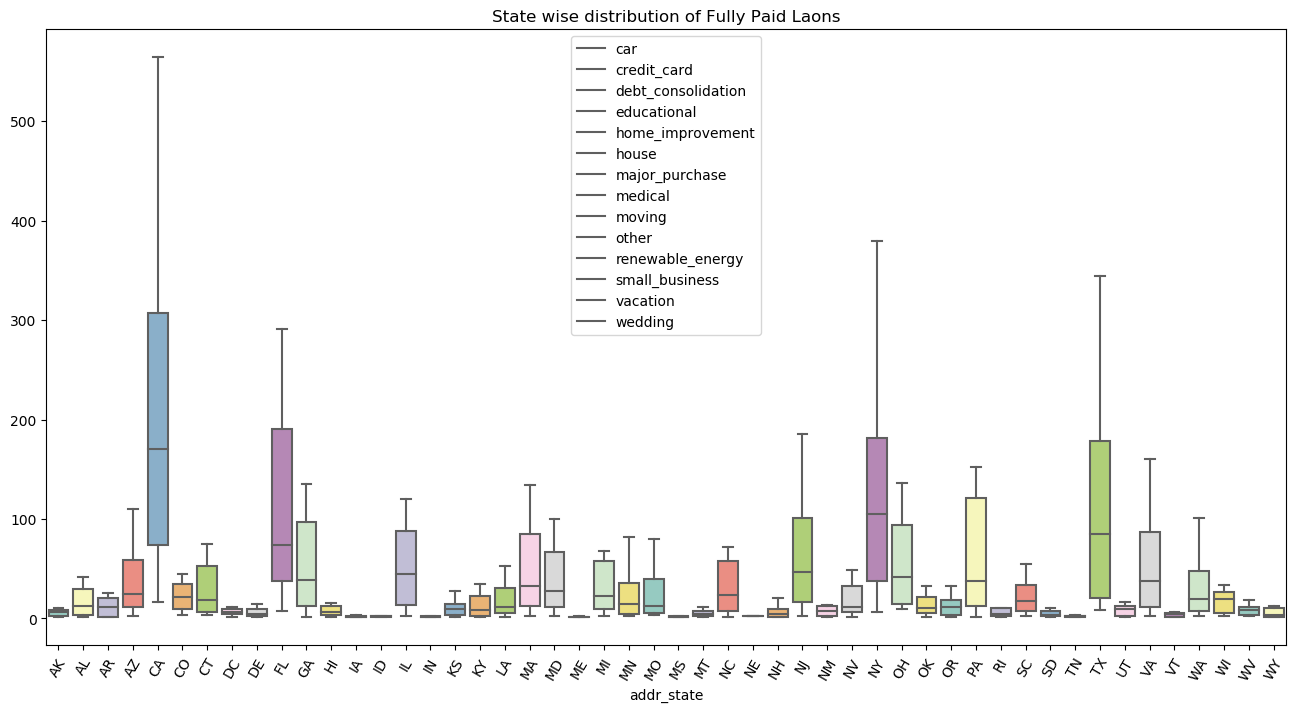

In [136]:
# State wise distribution of Fully Paid Laons
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(16,8))
sns.boxplot(data=fully_paid_pvt_df, showfliers=False, palette="Set3")
plt.xticks(rotation=60)
plt.title("State wise distribution of Fully Paid Laons")
plt.legend(fully_paid_pvt_df.index)
plt.show()

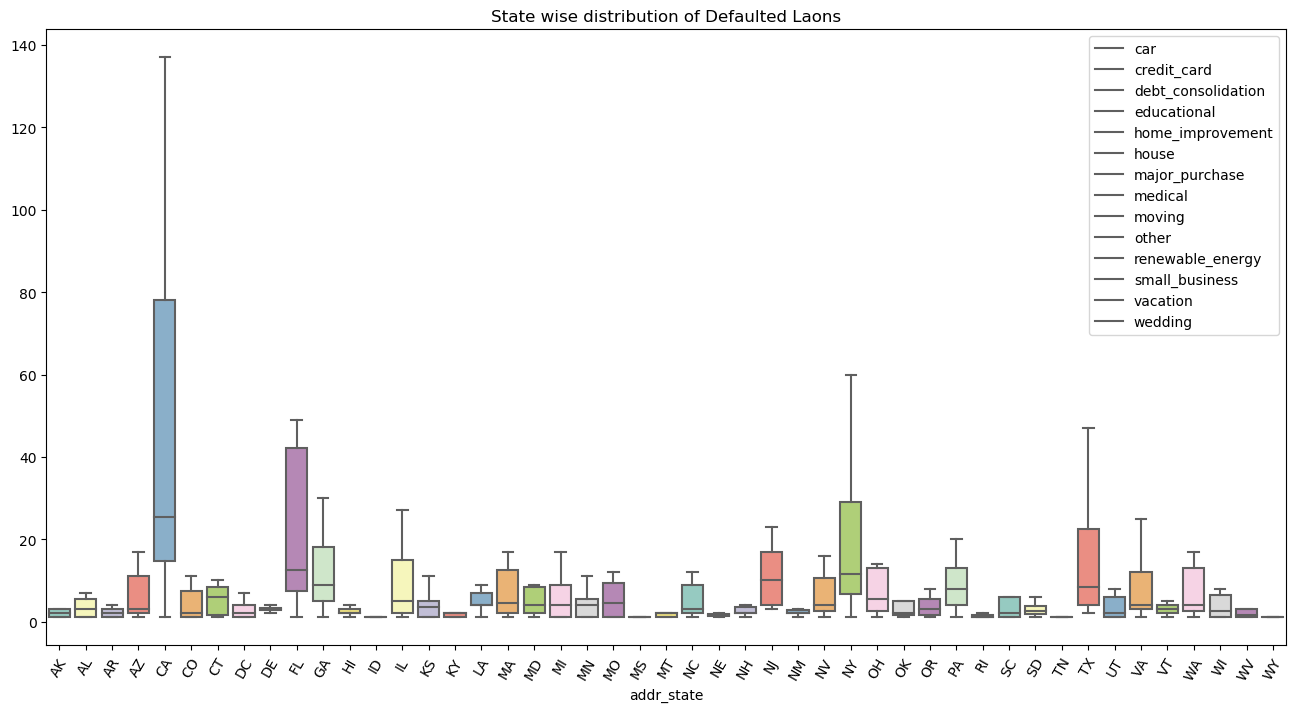

Observations:
	The loan taken for debt consolidation has highest chances of defaulting
	The state CA has highest % of defaulters


In [137]:
# State wise distribution of Defaulted Laons
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(16,8))
ax = sns.boxplot(data=default_pvt_df, showfliers=False, palette="Set3")
plt.xticks(rotation=60)
plt.title("State wise distribution of Defaulted Laons")
plt.legend(default_pvt_df.index, loc=1)
plt.show()

# The loan taken for debt consolidation has highest chances of defaulting
# The state CA has highest percentage of defaulters
print('Observations:\n\tThe loan taken for debt consolidation has highest chances of defaulting')
print('\tThe state CA has highest % of defaulters')

###### Analysis of home owner and loan status

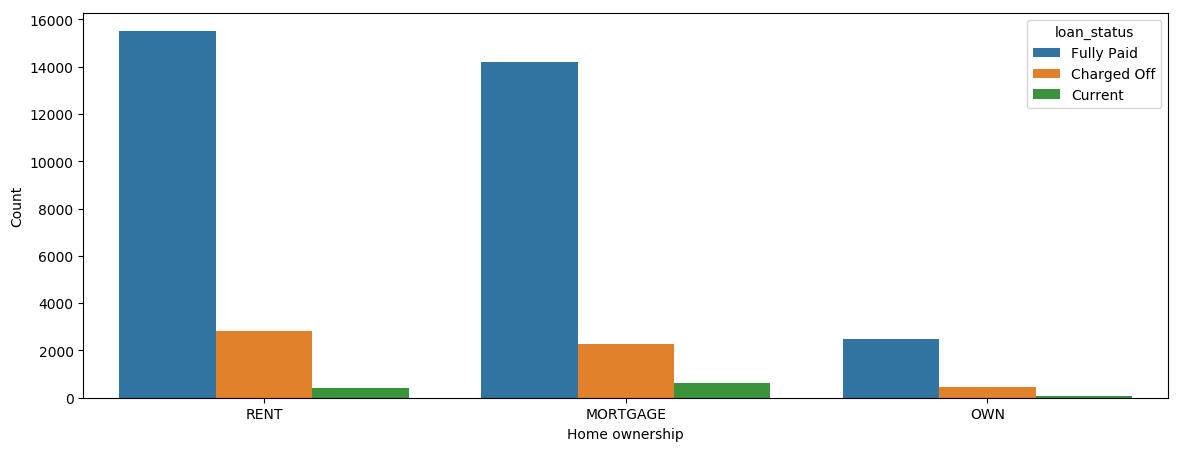

In [138]:
# count plot for home_ownership
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(14,5))
fig = sns.countplot(loandf.home_ownership.dropna(), order = loandf.home_ownership.value_counts().index,hue=loandf.loan_status)
fig.set(xlabel='Home ownership', ylabel='Count')
plt.show()

###### Analysis of address, verification status, home ownership and loan status

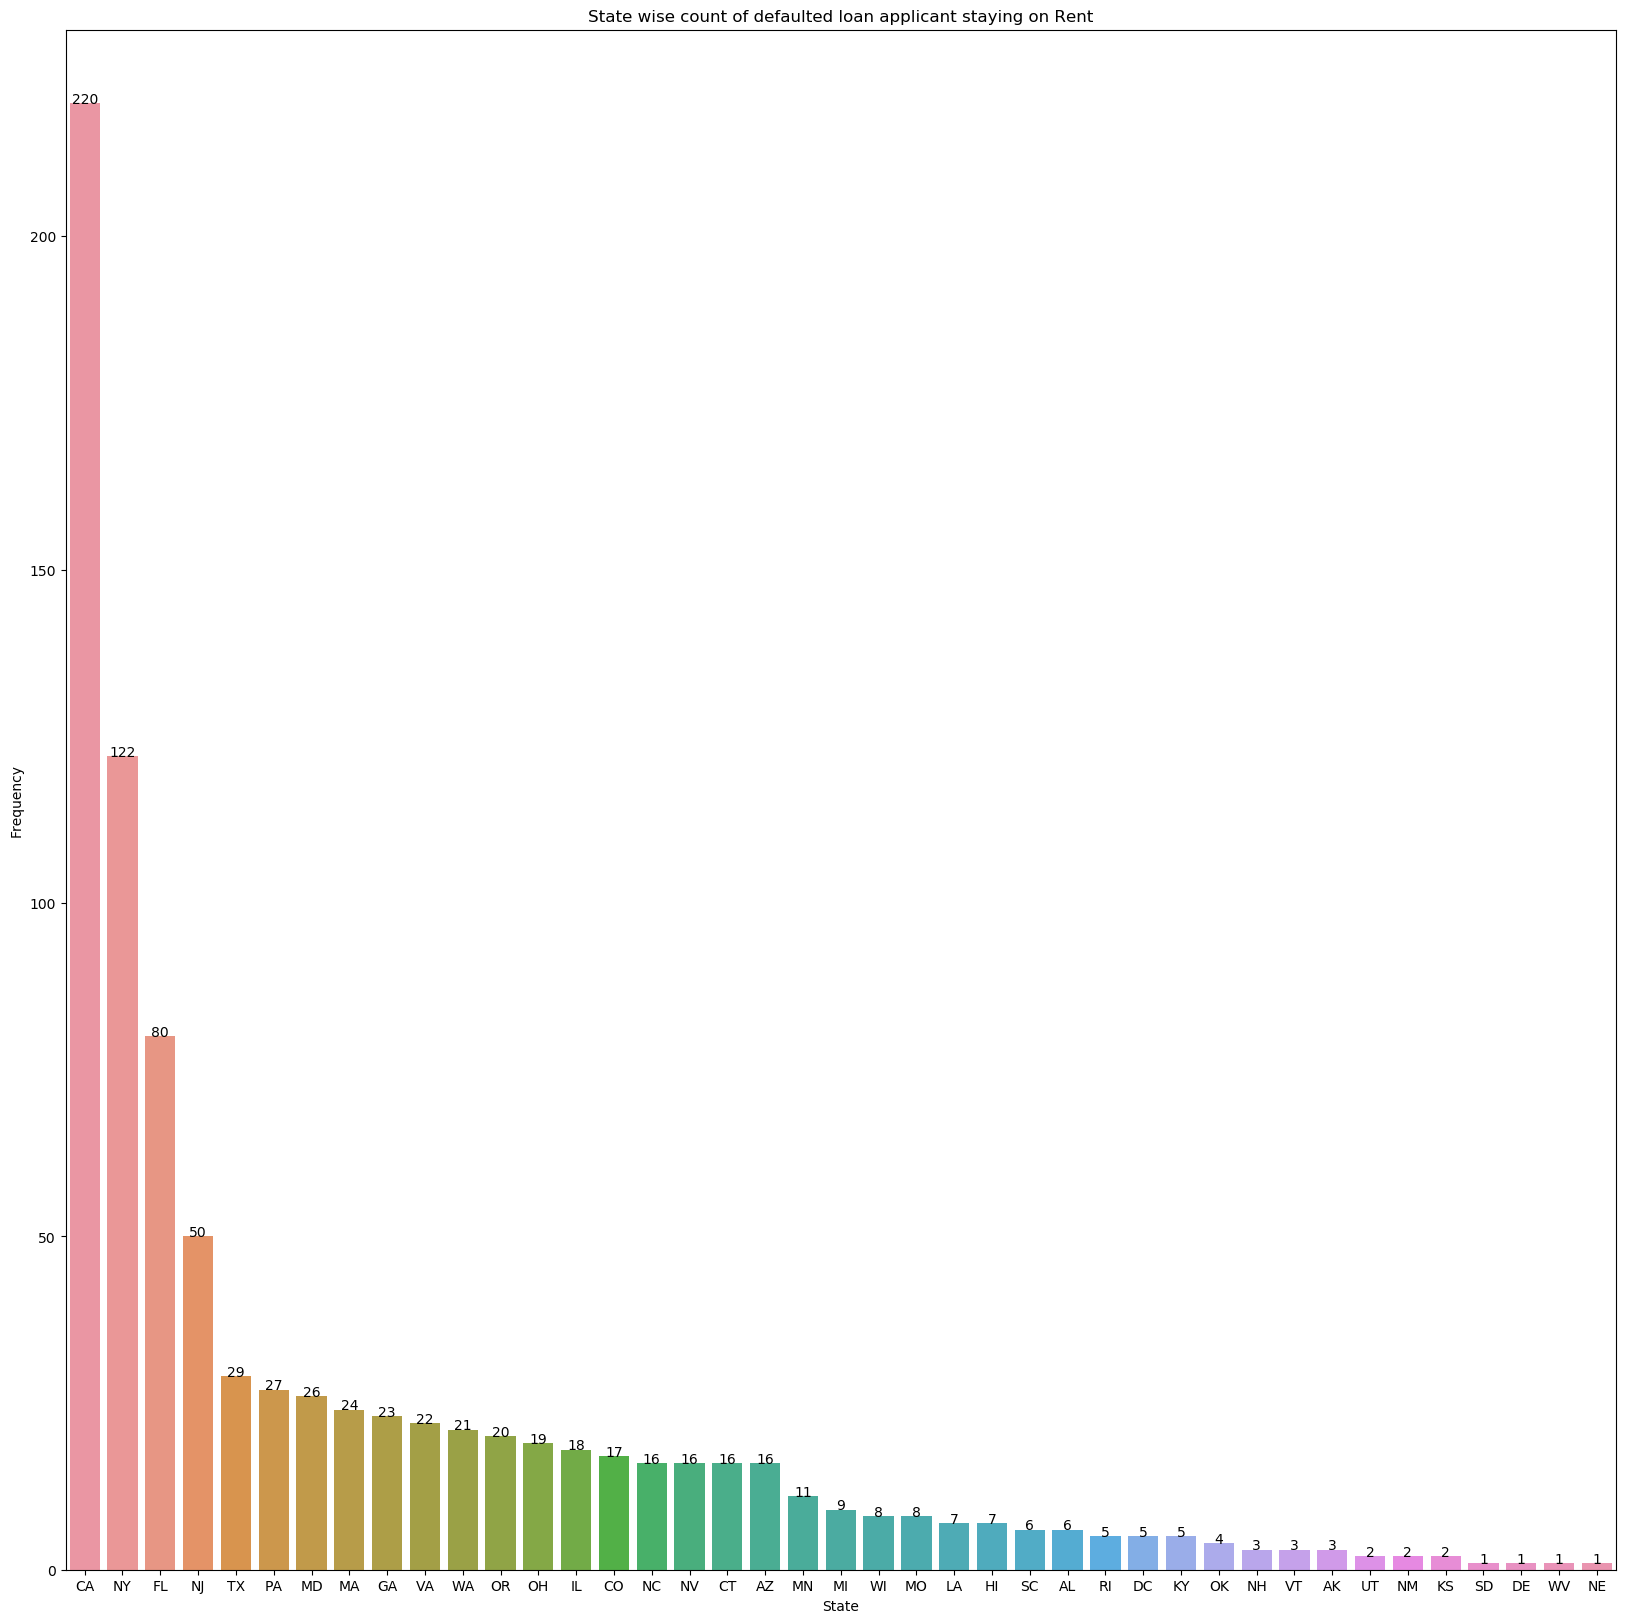

Observation: The State CA has maximum number of defaulted loan applicant staying on Rent.


In [139]:
not_verified = default_df.loc[fully_paid_df.verification_status == 'Not Verified']
rent = pd.DataFrame(not_verified[not_verified.home_ownership == 'RENT'])
g1 = pd.DataFrame(rent.addr_state.value_counts())
# Plot year wise bar chart of issue_d column 
draw_bar_chart(g1, g1.index, "addr_state", 20, 20,
               'State wise count of defaulted loan applicant staying on Rent',
               'State', 'Frequency', None,
               'Observation: The State CA has maximum number of defaulted loan applicant staying on Rent.',
              True)

###### Analysis of verification status and loan status based on annual income

In [140]:
# Groupby(verification status,loan_status) : Take average of annual_inc

# Create pivot table first
default_pvt_df = pd.pivot_table(default_df, index=["verification_status"], values="annual_inc", columns="loan_status_modf", aggfunc=[np.mean])
default_pvt_df.columns = default_pvt_df.columns.droplevel(0)
default_pvt_df

loan_status_modf,Default
verification_status,
Not Verified,52656.388622
Source Verified,57101.960248
Verified,66790.073141


In [141]:
# Inference:
# in each of the verification_status group(Not verified,source verified,verified), Fully paid always has higher average annual_inc than charged off
fully_paid_pvt_df = pd.pivot_table(fully_paid_df, index=["verification_status"], values="annual_inc", columns="loan_status_modf", aggfunc=[np.mean])
fully_paid_pvt_df.columns = fully_paid_pvt_df.columns.droplevel(0)
fully_paid_pvt_df

loan_status_modf,Good
verification_status,
Not Verified,58655.369195
Source Verified,63014.859389
Verified,75369.661693


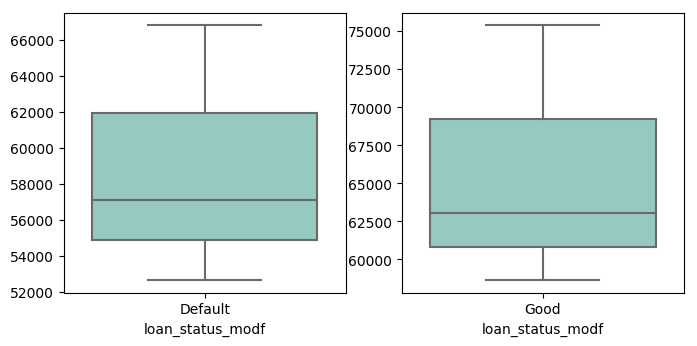

In [142]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
sns.boxplot(data=default_pvt_df, showfliers=False, palette="Set3")

plt.subplot(2, 2, 2)
sns.boxplot(data=fully_paid_pvt_df, showfliers=False, palette="Set3")

plt.xticks()
plt.show()

In [143]:
loan_status_pvt_df = pd.pivot_table(loandf, index=["interest_rate_bracket"], values="install_incm_per", columns=["loan_status_modf","term"], aggfunc=[np.median])
loan_status_pvt_df.columns = loan_status_pvt_df.columns.droplevel(0)
print("\nInference from below table:\n\t For each term term loan the installment to income ration of for each of the interest slabs  are as below.\n\t This influences whether a loan is likely to be defaulted or not:\n")
loan_status_pvt_df




Inference from below table:
	 For each term term loan the installment to income ration of for each of the interest slabs  are as below.
	 This influences whether a loan is likely to be defaulted or not:



loan_status_modf        Default                Good          
term                         36        60        36        60
interest_rate_bracket                                        
10-15                  6.592650  6.645357  6.123769  5.800984
15-20                  7.208333  7.200923  7.100310  6.657143
20-25                  9.570312  9.347769  7.218121  8.037000
5-10                   5.399887  4.921428  4.956250  3.875707

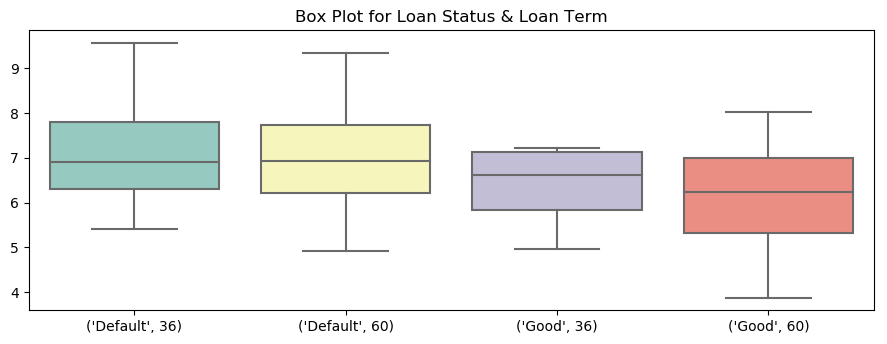

In [144]:
plt.rcdefaults() # Restore the rc params from Matplotlib’s internal defaults.
plt.figure(figsize=(24,8))

plt.subplot(2, 2, 1)
sns.boxplot(data=loan_status_pvt_df, showfliers=False, palette="Set3")
plt.title("Box Plot for Loan Status & Loan Term")
plt.show()